## Deep Learning Approach

In [1]:
#import appropriate packages

import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
import numpy
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score as cvs
from sklearn.model_selection import StratifiedShuffleSplit
import dask.dataframe as dd
from scipy.stats import skew
from sklearn import preprocessing
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier

from tab2img.converter import Tab2Img

#deep learning
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.callbacks import EarlyStopping
import torch
from torch import nn
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.impute import SimpleImputer

## Data Load

In [2]:
#colet_deep_data = pd.DataFrame()
#temp = pd.read_csv(r'E:\Deakin\SIT724\Data Set\Data\COLET\To upload\colet_deep_learning_data.csv', iterator = True, chunksize = 1000)
#colet_deep_data = pd.concat(temp, ignore_index=True)

In [3]:
#print(colet_deep_data.shape[0])

In [4]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

#colet_deep_data.isnull().sum(axis=0)

In [5]:
# Identify number of entrires for each class/participant

#class balancing? 

# GAZE

In [6]:
#check other COLET dataframes
colet_gaze = pd.read_csv(r'E:\Deakin\SIT724\Data Set\Data\COLET\To upload\colet_gaze_concat.csv')


In [7]:
#remove missing values

colet_gaze = colet_gaze.dropna()

In [8]:
#reset this as we are working with the index 

colet_gaze = colet_gaze.reset_index()

In [9]:
## Testing below

Test the below: 

- get the rolling feature value for the window, and then this becomes its own feature 

- apply the rolling using the windows created 

- class imbalance 

In [10]:
#calculate the difference between the earliest and latest timestamp by participant and task

#colet_gaze['index_diff']= colet_gaze.reset_index().groupby(['file', 'task'])['index'].transform(lambda x: x.max() - x.min())

In [11]:
#colet_gaze['window_size'] = round(colet_gaze['index_diff']/6)

In [12]:
#if between min and min + window_size then 1

In [13]:
# Create a new field 'window' with overlapping windows
#colet_gaze['window'] = colet_gaze.groupby(['file', 'task'])['index'].transform(lambda x: pd.Series(range(1, len(x) - 1)).rolling(window=int(colet_gaze['window_size'].iloc[0]), min_periods=1).apply(lambda y: y.iloc[-1] if not y.empty else None))

In [14]:
# Define the window size
#window_size = 5

# Group by 'file' and 'task', and calculate the window based on the index
#colet_gaze['window'] = colet_gaze.groupby(['file', 'task']).apply(lambda x: pd.RangeIndex(start=1, stop=len(x)+1) + window_size).values


In [15]:
#colet_gaze[colet_gaze['file'] == 'Task1_Subject_9.xlsx']

import pandas as pd

# Assuming your DataFrame is named colet_gaze and contains 'index', 'file', and 'task' columns

# Define the window function
def get_window_number(index):
    group_size = 3
    window_size = 5

    if index % window_size == 0:
        return 1
    else:
        group_index = (index // window_size) * group_size
        if index >= group_index and index < group_index + window_size:
            return (index - group_index) // group_size + 1
        else:
            return None

# Group by 'file' and 'task' and create window columns
grouped = colet_gaze.groupby(['file', 'task'])

for group_name, group_data in grouped:
    for i in range(1, 6):  # Assuming 5 windows
        window_col = f'window_{i}_{group_name[0]}_{group_name[1]}'
        colet_gaze.loc[group_data.index, window_col] = group_data['index'].apply(lambda x: 1 if get_window_number(x) == i else 0)

colet_gaze

In [16]:
## Testing above 

In [17]:
#calculate the difference between the earliest and latest timestamp by participant and task

colet_gaze['timestamp_diff']= (colet_gaze.groupby(['file', 'task'])['gaze_timestamp'].transform('max')-
             colet_gaze.groupby(['file', 'task'])['gaze_timestamp'].transform('min'))

In [18]:
#create an even number of window sizes

#if we want to have a set window size use below
#colet_gaze['window_size'] = 50
#original approach, use below
#29/08/2024 - attempting 20 windows (from 15 windows)
colet_gaze['window_size'] = round(colet_gaze['timestamp_diff']/40)
# 1 window, use below
#colet_gaze['window_size'] = round(colet_gaze['timestamp_diff']/1)

In [19]:
# create a fixed window size

# 1 window
#max_category_n = 1
#original approach, use below
#29/08/2024 - attempting 20 windows (from 16 windows)
max_category_n = 41
#if setting a set window size, use below
#max_category_n = round(colet_gaze['timestamp_diff']/colet_gaze['window_size'] ).astype(int).max()

In [20]:
#include a 'min timestamp' for calculations below

colet_gaze['min_gaze_timestamp'] = colet_gaze.groupby(['file', 'task'])['gaze_timestamp'].transform('min')

In [21]:
# Define a function to apply the logic and assign categories
def assign_category(row):
    max_category = max_category_n
    for i in range(1, max_category + 1):
        lower_bound = row['min_gaze_timestamp'] + (row['window_size'] * (i - 1))
        upper_bound = row['min_gaze_timestamp'] + (row['window_size'] * i)
        if row['gaze_timestamp'] >= lower_bound and row['gaze_timestamp'] <= upper_bound:
            return i
    return None

# Apply the function to create the 'category' column
colet_gaze['category'] = colet_gaze.apply(assign_category, axis=1)

#print(colet_gaze)

In [22]:
colet_gaze

,index,gaze_timestamp,world_index,confidence,norm_pos_x,norm_pos_y,base_data,gaze_point_3d_x,gaze_point_3d_y,gaze_point_3d_z,...,eye_center1_3d_z,gaze_normal1_x,gaze_normal1_y,gaze_normal1_z,file,task,timestamp_diff,window_size,min_gaze_timestamp,category
0,0,5410.551715,0,0.999499,0.446264,0.846886,'5410.549631999999-0 5410.553797-1',-6.720630,-31.252881,80.700682,...,-21.600300,0.277597,-0.391313,0.877391,Task1_Subject_1.xlsx,1,33.656181,1.0,5410.551715,1.0
1,1,5410.555834,0,0.999653,0.446534,0.847007,'5410.557871999999-0 5410.553797-1',-6.690706,-31.298388,80.793260,...,-21.600300,0.277597,-0.391313,0.877391,Task1_Subject_1.xlsx,1,33.656181,1.0,5410.551715,1.0
2,2,5410.559774,0,0.999648,0.446660,0.846410,'5410.557871999999-0 5410.561675-1',-6.664575,-31.211650,80.708374,...,-21.600300,0.278049,-0.390575,0.877576,Task1_Subject_1.xlsx,1,33.656181,1.0,5410.551715,1.0
3,3,5410.563583,0,0.999656,0.446442,0.845542,'5410.565490999999-0 5410.561675-1',-6.689463,-31.118351,80.664979,...,-21.600300,0.278049,-0.390575,0.877576,Task1_Subject_1.xlsx,1,33.656181,1.0,5410.551715,1.0
4,4,5410.568291,0,0.999565,0.446472,0.845614,'5410.565490999999-0 5410.571091999999-1',-6.683464,-31.115105,80.640260,...,-21.600300,0.278153,-0.390681,0.877496,Task1_Subject_1.xlsx,1,33.656181,1.0,5410.551715,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898156,2077501,222043.332706,272,0.999866,0.515607,0.439272,'222043.33090499998-0 222043.334508-1',3.434937,0.810220,101.123017,...,-21.524028,0.327293,-0.097566,0.939872,Task1_Subject_9.xlsx,4,6709.032149,168.0,222017.460451,1.0
1898157,2077502,222043.336530,273,0.999767,0.514888,0.438728,'222043.33855199997-0 222043.334508-1',3.305292,0.857062,100.751790,...,-21.524028,0.327293,-0.097566,0.939872,Task1_Subject_9.xlsx,4,6709.032149,168.0,222017.460451,1.0
1898158,2077503,222043.340519,273,0.999846,0.514192,0.439384,'222043.33855199997-0 222043.34248599998-1',3.213693,0.802417,101.432418,...,-21.524028,0.325053,-0.097289,0.940678,Task1_Subject_9.xlsx,4,6709.032149,168.0,222017.460451,1.0
1898159,2077504,222043.344584,273,0.999875,0.508943,0.436278,'222043.346681-0 222043.34248599998-1',2.293070,1.059562,98.765386,...,-21.524028,0.325053,-0.097289,0.940678,Task1_Subject_9.xlsx,4,6709.032149,168.0,222017.460451,1.0


# PUPIL

In [23]:
colet_pupil = pd.read_csv(r'E:\Deakin\SIT724\Data Set\Data\COLET\To upload\colet_pupil_concat.csv')
colet_pupil.isnull().sum(axis=0)

pupil_timestamp               781802
world_index                   781802
eye_id                        781802
confidence                    781802
norm_pos_x                    781802
norm_pos_y                    781802
diameter                      781802
method                        781802
ellipse_center_x              781802
ellipse_center_y              782207
ellipse_axis_a                782207
ellipse_axis_b                782207
ellipse_angle                 782207
diameter_3d                  2871989
model_confidence             2871989
model_id                     2872024
sphere_center_x              2872024
sphere_center_y              2872024
sphere_center_z              2872024
sphere_radius                2872024
circle_3d_center_x           2872024
circle_3d_center_y           2883238
circle_3d_center_z           2883238
circle_3d_normal_x           2883238
circle_3d_normal_y           2883238
circle_3d_normal_z           2883238
circle_3d_radius             2883238
t

In [24]:
#drop missing values
colet_pupil = colet_pupil.dropna()

In [25]:
#calculate the difference between the earliest and latest timestamp by participant and task

colet_pupil['timestamp_diff']= (colet_pupil.groupby(['file', 'task'])['pupil_timestamp'].transform('max')-
             colet_pupil.groupby(['file', 'task'])['pupil_timestamp'].transform('min'))

In [26]:


#if we set the window size, use below to create an even number of window sizes
#colet_pupil['window_size'] = 50

#original approach below
#29/08/2024 - attempting 20 windows (from 15 windows)
colet_pupil['window_size'] = round(colet_pupil['timestamp_diff']/40)
# 1 window
#colet_pupil['window_size'] = round(colet_pupil['timestamp_diff']/1)

In [27]:
# create a fixed window size

#1 window
#max_category_n = 1

#original approach
#29/08/2024 - attempting 20 windows (from 16 windows)
max_category_n = 41

#if we set the window size, use below
#max_category_n = round(colet_pupil['timestamp_diff']/colet_pupil['window_size']).astype(int).max()

In [28]:
#include a 'min timestamp' for calculations below

colet_pupil['min_pupil_timestamp'] = colet_pupil.groupby(['file', 'task'])['pupil_timestamp'].transform('min')

In [29]:
# Define a function to apply the logic and assign categories
def assign_category(row):
    max_category = max_category_n
    for i in range(1, max_category + 1):
        lower_bound = row['min_pupil_timestamp'] + (row['window_size'] * (i - 1))
        upper_bound = row['min_pupil_timestamp'] + (row['window_size'] * i)
        if row['pupil_timestamp'] >= lower_bound and row['pupil_timestamp'] <= upper_bound:
            return i
    return None

# Apply the function to create the 'category' column
colet_pupil['category'] = colet_pupil.apply(assign_category, axis=1)



In [30]:
#check if it's applyign correctly

print(colet_pupil[colet_pupil['file'] == 'Task1_Subject_1.xlsx']['category'].unique())

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39.]


# BLINK

In [31]:
colet_blink = pd.read_csv(r'E:\Deakin\SIT724\Data Set\Data\COLET\To upload\colet_blink_concat.csv')
colet_blink.isnull().sum(axis=0)

ID                   0
start_timestamp      0
duration             0
end_timestamp        0
start_frame_index    0
index                0
end_frame_index      0
confidence           0
filter_response      0
base_Data            0
file                 0
task                 0
dtype: int64

In [32]:
#calculate the difference between the earliest and latest timestamp by participant and task

colet_blink['timestamp_diff']= (colet_blink.groupby(['file', 'task'])['start_timestamp'].transform('max')-
             colet_blink.groupby(['file', 'task'])['start_timestamp'].transform('min'))

In [33]:
#create an even number of window sizes

#1 window
#colet_blink['window_size'] = 1

#if we set a window size use below
#colet_blink['window_size'] = 50

#opriginal approach use below
#29/08/2024 - attempting 20 windows (from 16 windows)
colet_blink['window_size'] = round(colet_blink['timestamp_diff']/40)

In [34]:
#create a fixed window size

#1 window
#max_category_n = 1

#if setting window size use below
#max_category_n = round(colet_blink['timestamp_diff']/colet_blink['window_size']).astype(int).max()

#original approach
max_category_n = 41

In [35]:
#include a 'min timestamp' for calculations below

colet_blink['min_blink_timestamp'] = colet_blink.groupby(['file', 'task'])['start_timestamp'].transform('min')

In [36]:
# Define a function to apply the logic and assign categories
def assign_category(row):
    max_category = max_category_n
    for i in range(1, max_category + 1):
        lower_bound = row['min_blink_timestamp'] + (row['window_size'] * (i - 1))
        upper_bound = row['min_blink_timestamp'] + (row['window_size'] * i)
        if row['start_timestamp'] >= lower_bound and row['start_timestamp'] <= upper_bound:
            return i
    return None

# Apply the function to create the 'category' column
colet_blink['category'] = colet_blink.apply(assign_category, axis=1)



In [37]:
colet_blink

,ID,start_timestamp,duration,end_timestamp,start_frame_index,index,end_frame_index,confidence,filter_response,base_Data,file,task,timestamp_diff,window_size,min_blink_timestamp,category
0,1,5437.625617,0.236131,5437.861748,37.0,40.0,44.0,0.703872,'0.5068225043614704 0.5512669488059149 0.59571...,'5437.625617 5437.629564 5437.633621 5437.6378...,Task1_Subject_1.xlsx,1,6.535944,0.0,5437.625617,1.0
1,2,5444.161561,0.180073,5444.341634,231.0,233.0,236.0,0.553669,'0.5048782729116744 0.5493227173561188 0.59287...,'5444.161561 5444.165642 5444.169793 5444.1755...,Task1_Subject_1.xlsx,1,6.535944,0.0,5437.625617,NaN
2,1,471465.723115,0.252434,471465.975549,21.0,24.0,28.0,0.659305,'0.53595171449361 0.5822480107899064 0.6061400...,'471465.723115 471465.731078 471465.7310899999...,Task1_Subject_10.xlsx,1,0.000000,0.0,471465.723115,1.0
3,1,8419.904790,0.203903,8420.108693,16.0,19.0,22.0,0.671161,'0.5366363953239319 0.5810808397683763 0.62552...,'8419.90479 8419.908641 8419.912594000001 8419...,Task1_Subject_11.xlsx,1,41.611652,1.0,8419.904790,1.0
4,2,8422.874139,0.166438,8423.040577,105.0,107.0,110.0,0.541905,'0.5358719345469952 0.5803163789914397 0.62476...,'8422.874139000001 8422.877731 8422.8813280000...,Task1_Subject_11.xlsx,1,41.611652,1.0,8419.904790,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1711,3,228712.420777,0.168113,228712.588890,287.0,289.0,292.0,0.554141,'0.5037201405857574 0.5500164368820537 0.59631...,'228712.420777 228712.420938 228712.428812 228...,Task1_Subject_9.xlsx,4,36.144147,1.0,228685.525146,27.0
1712,1,228718.560785,0.132246,228718.693031,23.0,25.0,27.0,0.417348,'0.531989059581162 0.5406546851960738 0.548623...,'228718.56078499998 228718.56080099999 228718....,Task1_Subject_9.xlsx,4,36.144147,1.0,228685.525146,34.0
1713,2,228719.464743,0.168152,228719.632895,50.0,52.0,55.0,0.534863,'0.5009343921762599 0.5472306884725565 0.57108...,'228719.464743 228719.46478399998 228719.47291...,Task1_Subject_9.xlsx,4,36.144147,1.0,228685.525146,34.0
1714,3,228719.940827,0.164094,228720.104921,64.0,66.0,69.0,0.507862,'0.5114266499435292 0.5577229462398255 0.58064...,'228719.94082699998 228719.94083399998 228719....,Task1_Subject_9.xlsx,4,36.144147,1.0,228685.525146,35.0


# ANNOTATION

In [38]:
colet_annot = pd.read_csv(r'E:\Deakin\SIT724\Data Set\Data\COLET\To upload\colet_annot_concat.csv')
colet_annot.isnull().sum(axis=0)

mental_1         0
physical_1       0
temporal_1       0
perforamnce_1    0
effort_1         0
frustation_1     0
mean_1           0
file             0
task             0
dtype: int64

In [39]:
#only really need mean_1 for the DV
colet_annot = colet_annot[['file', 'task', 'mean_1']]

### no need to do any additional work on annotation, but do need to merge it to the dataframes at the end

# Additional features to allow for aggregation by windows

# Gaze features

## Fixations and Saccades

In [40]:
colet_gaze

,index,gaze_timestamp,world_index,confidence,norm_pos_x,norm_pos_y,base_data,gaze_point_3d_x,gaze_point_3d_y,gaze_point_3d_z,...,eye_center1_3d_z,gaze_normal1_x,gaze_normal1_y,gaze_normal1_z,file,task,timestamp_diff,window_size,min_gaze_timestamp,category
0,0,5410.551715,0,0.999499,0.446264,0.846886,'5410.549631999999-0 5410.553797-1',-6.720630,-31.252881,80.700682,...,-21.600300,0.277597,-0.391313,0.877391,Task1_Subject_1.xlsx,1,33.656181,1.0,5410.551715,1.0
1,1,5410.555834,0,0.999653,0.446534,0.847007,'5410.557871999999-0 5410.553797-1',-6.690706,-31.298388,80.793260,...,-21.600300,0.277597,-0.391313,0.877391,Task1_Subject_1.xlsx,1,33.656181,1.0,5410.551715,1.0
2,2,5410.559774,0,0.999648,0.446660,0.846410,'5410.557871999999-0 5410.561675-1',-6.664575,-31.211650,80.708374,...,-21.600300,0.278049,-0.390575,0.877576,Task1_Subject_1.xlsx,1,33.656181,1.0,5410.551715,1.0
3,3,5410.563583,0,0.999656,0.446442,0.845542,'5410.565490999999-0 5410.561675-1',-6.689463,-31.118351,80.664979,...,-21.600300,0.278049,-0.390575,0.877576,Task1_Subject_1.xlsx,1,33.656181,1.0,5410.551715,1.0
4,4,5410.568291,0,0.999565,0.446472,0.845614,'5410.565490999999-0 5410.571091999999-1',-6.683464,-31.115105,80.640260,...,-21.600300,0.278153,-0.390681,0.877496,Task1_Subject_1.xlsx,1,33.656181,1.0,5410.551715,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898156,2077501,222043.332706,272,0.999866,0.515607,0.439272,'222043.33090499998-0 222043.334508-1',3.434937,0.810220,101.123017,...,-21.524028,0.327293,-0.097566,0.939872,Task1_Subject_9.xlsx,4,6709.032149,168.0,222017.460451,1.0
1898157,2077502,222043.336530,273,0.999767,0.514888,0.438728,'222043.33855199997-0 222043.334508-1',3.305292,0.857062,100.751790,...,-21.524028,0.327293,-0.097566,0.939872,Task1_Subject_9.xlsx,4,6709.032149,168.0,222017.460451,1.0
1898158,2077503,222043.340519,273,0.999846,0.514192,0.439384,'222043.33855199997-0 222043.34248599998-1',3.213693,0.802417,101.432418,...,-21.524028,0.325053,-0.097289,0.940678,Task1_Subject_9.xlsx,4,6709.032149,168.0,222017.460451,1.0
1898159,2077504,222043.344584,273,0.999875,0.508943,0.436278,'222043.346681-0 222043.34248599998-1',2.293070,1.059562,98.765386,...,-21.524028,0.325053,-0.097289,0.940678,Task1_Subject_9.xlsx,4,6709.032149,168.0,222017.460451,1.0


In [41]:
#get the difference between the previous value for each row

colet_gaze.sort_values(['file', 'gaze_timestamp', 'task', 'category'], inplace=True)
colet_gaze['gaze_diff'] = colet_gaze.groupby(['file', 'task', 'category'])['gaze_timestamp'].diff()
colet_gaze['x_diff'] = colet_gaze.groupby(['file', 'task', 'category'])['gaze_point_3d_x'].diff()
colet_gaze['y_diff'] = colet_gaze.groupby(['file', 'task', 'category'])['gaze_point_3d_y'].diff()
colet_gaze['z_diff'] = colet_gaze.groupby(['file', 'task', 'category'])['gaze_point_3d_z'].diff()

In [42]:
#square x, y and z

colet_gaze['x_diff^2'] = colet_gaze['x_diff']**2
colet_gaze['y_diff^2'] = colet_gaze['y_diff']**2
colet_gaze['z_diff^2'] = colet_gaze['z_diff']**2

In [43]:
#sum x y and z
column_names = ['x_diff^2','y_diff^2','z_diff^2']

colet_gaze['sum']= colet_gaze[column_names].sum(axis=1)

In [44]:
#take sqrt of this value

colet_gaze['sqrt']= np.sqrt(colet_gaze['sum'])

In [45]:
#divide by displacement to obtain velocity

colet_gaze['velocity'] = colet_gaze['gaze_diff'] / colet_gaze['sqrt']

In [46]:
# skewness of velocity

colet_gaze['skew_velocity'] = colet_gaze.groupby(['file', 'task', 'category'])['velocity'].transform(lambda x: x.skew())

# kurtosis of velocity

colet_gaze['kurtosis_velocity'] = colet_gaze.groupby(['file', 'task', 'category'])['velocity'].transform(lambda x: x.kurtosis())

In [47]:
# skewness of duration

colet_gaze['skew_gaze_duration'] = colet_gaze.groupby(['file', 'task', 'category'])['gaze_diff'].transform(lambda x: x.skew())

#kurtosis of duration

colet_gaze['kurtosis_gaze_duration'] = colet_gaze.groupby(['file', 'task', 'category'])['gaze_diff'].transform(lambda x: x.kurtosis())

In [48]:
#fixation flag

colet_gaze['fixation_flag'] = np.where((colet_gaze['velocity'] < 0.45) & (colet_gaze['gaze_diff']) > 0.55, 1, 0)

In [49]:
#grouping fixations (as the authors did the same thing)

colet_gaze['fix_group'] = colet_gaze.groupby(['file', 'task', 'category'])['fixation_flag'].diff().abs().cumsum().fillna(0).astype(int) + 1

In [50]:
#counting fixations 1 time! 

colet_gaze['fixations_count'] = colet_gaze.groupby(['file', 'task', 'category'])['fix_group'].transform('nunique')

In [51]:
#fixations per second

colet_gaze['fix_per_sec'] = colet_gaze['fixations_count'] / colet_gaze['timestamp_diff']

In [52]:
#saccade flag
colet_gaze['saccade_flag'] = np.where((colet_gaze['velocity'] > 0.45) & (colet_gaze['gaze_diff']) < 0.55, 1, 0)

In [53]:
#saccades per second
colet_gaze['saccade_sum'] = colet_gaze.groupby(['file', 'task', 'category'])['saccade_flag'].transform('sum')

colet_gaze['sac_per_sec'] = colet_gaze['saccade_sum'] / colet_gaze['timestamp_diff']

In [54]:
#max eye movement velocity
colet_gaze['max_movement_velocity'] = colet_gaze.groupby(['file', 'task', 'category'])['velocity'].transform('max')

#min eye movement velocity
colet_gaze['min_movement_velocity'] = colet_gaze.groupby(['file', 'task', 'category'])['velocity'].transform('min')

In [55]:
#skewness kurtosis can't work on nulls
colet_gaze = colet_gaze.dropna()

#skewness max velocity

colet_gaze['skew_max_velocity'] = colet_gaze.groupby(['task', 'category'])['max_movement_velocity'].transform(lambda x: x.skew())

#skewness max kurtosis

colet_gaze['kurtosis_max_velocity'] = colet_gaze.groupby(['task', 'category'])['max_movement_velocity'].transform(lambda x: x.kurtosis())

#skewness min velocity

colet_gaze['skew_min_velocity'] = colet_gaze.groupby(['task', 'category'])['min_movement_velocity'].transform(lambda x: x.skew())

#kurtosis min velocity

colet_gaze['kurtosis_min_velocity'] = colet_gaze.groupby(['task', 'category'])['min_movement_velocity'].transform(lambda x: x.kurtosis())

In [56]:
colet_gaze

,index,gaze_timestamp,world_index,confidence,norm_pos_x,norm_pos_y,base_data,gaze_point_3d_x,gaze_point_3d_y,gaze_point_3d_z,...,fix_per_sec,saccade_flag,saccade_sum,sac_per_sec,max_movement_velocity,min_movement_velocity,skew_max_velocity,kurtosis_max_velocity,skew_min_velocity,kurtosis_min_velocity
415884,424633,4659.171724,0,0.999934,0.467982,0.841412,'4659.173514-0 4659.169934-1',-3.374369,-28.127372,73.947970,...,0.070213,1,248.0,8.706452,0.439285,0.000517,5.880479,33.191290,0.997508,0.122931
415885,424634,4659.175874,0,0.999912,0.467992,0.841952,'4659.173514-0 4659.178234999999-1',-3.372870,-28.163546,73.927925,...,0.070213,1,248.0,8.706452,0.439285,0.000517,5.880479,33.191290,0.997508,0.122931
415886,424635,4659.179746,0,0.999956,0.467042,0.841566,'4659.181258-0 4659.178234999999-1',-3.479495,-28.023615,73.637258,...,0.070213,1,248.0,8.706452,0.439285,0.000517,5.880479,33.191290,0.997508,0.122931
415887,424636,4659.183226,0,0.999976,0.467126,0.841238,'4659.181258-0 4659.185194-1',-3.466174,-27.978763,73.589596,...,0.070213,1,248.0,8.706452,0.439285,0.000517,5.880479,33.191290,0.997508,0.122931
415888,424637,4659.188242,0,0.999907,0.468032,0.841165,'4659.19129-0 4659.185194-1',-3.364733,-28.081880,73.881275,...,0.070213,1,248.0,8.706452,0.439285,0.000517,5.880479,33.191290,0.997508,0.122931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1892507,2071206,228726.473798,258,0.999584,0.551797,0.533421,'228726.46905299998-0 228726.47854299998-1',12.744060,-10.693456,137.204654,...,0.000894,1,9955.0,1.483821,1.473069,0.000050,-0.994930,-0.801708,3.747977,16.303572
1892508,2071207,228726.478479,259,0.999399,0.551946,0.534139,'228726.478416-0 228726.47854299998-1',12.789399,-10.793831,137.326583,...,0.000894,1,9955.0,1.483821,1.473069,0.000050,-0.994930,-0.801708,3.747977,16.303572
1892509,2071208,228726.484354,259,0.999110,0.552357,0.533331,'228726.490165-0 228726.47854299998-1',12.919169,-10.724065,137.732324,...,0.000894,1,9955.0,1.483821,1.473069,0.000050,-0.994930,-0.801708,3.747977,16.303572
1892510,2071209,228726.489828,259,0.998905,0.550968,0.537481,'228726.490165-0 228726.489491-1',12.807938,-11.423754,139.895061,...,0.000894,1,9955.0,1.483821,1.473069,0.000050,-0.994930,-0.801708,3.747977,16.303572


In [57]:
#select columns of interest 
colet_gaze = colet_gaze[['file', 'task', 'category', 'fixations_count', 'sac_per_sec', 'fix_per_sec', 'max_movement_velocity', 'min_movement_velocity', 'saccade_sum'
                         , 'skew_max_velocity', 'kurtosis_max_velocity', 'skew_min_velocity', 'kurtosis_min_velocity'
                        ]]

In [58]:
#remove duplicates
colet_gaze = colet_gaze.drop_duplicates()

In [59]:
#the max values are resulting in infinite values, instead replacing these infinite values with the next highest max value

# Replace 'inf' values with the maximum 'max_movement_velocity' grouped by 'file', 'task', and 'category'
colet_gaze['max_movement_velocity'] = colet_gaze['max_movement_velocity'].replace([np.inf], np.nan)  # Replace 'inf' with nan temporarily

max_values = colet_gaze.groupby(['file', 'task', 'category'])['max_movement_velocity'].transform('max')
colet_gaze['max_movement_velocity'] = colet_gaze['max_movement_velocity'].fillna(max_values)  # Fill nan values with group max

In [60]:
colet_gaze.to_csv('colet_gaze_features.csv', index = False)

In [61]:
colet_gaze

,file,task,category,fixations_count,sac_per_sec,fix_per_sec,max_movement_velocity,min_movement_velocity,saccade_sum,skew_max_velocity,kurtosis_max_velocity,skew_min_velocity,kurtosis_min_velocity
415884,Task1_Subject_1.xlsx,2,1.0,2.0,8.706452,0.070213,0.439285,0.000517,248.0,5.880479,33.191290,0.997508,0.122931
416132,Task1_Subject_1.xlsx,2,2.0,4.0,8.636238,0.140427,0.851172,0.000613,246.0,2.154502,4.348450,2.283504,5.290912
416379,Task1_Subject_1.xlsx,2,3.0,2.0,8.460705,0.070213,0.430260,0.000456,241.0,1.938105,5.024899,2.768903,8.835822
416620,Task1_Subject_1.xlsx,2,4.0,2.0,6.635159,0.070213,0.423138,0.000314,189.0,2.380927,6.851353,1.638579,2.117527
416809,Task1_Subject_1.xlsx,2,5.0,4.0,8.636238,0.140427,0.743421,0.000540,246.0,1.837907,2.469842,2.295575,6.138553
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726530,Task1_Subject_9.xlsx,2,20.0,2.0,10.953074,0.088331,0.074836,0.000506,248.0,2.279773,6.818873,1.915517,4.862047
726778,Task1_Subject_9.xlsx,2,21.0,2.0,10.820577,0.088331,0.262327,0.000148,245.0,2.748169,8.575698,3.480232,12.874432
727023,Task1_Subject_9.xlsx,2,22.0,2.0,10.908908,0.088331,0.052519,0.000215,247.0,2.216811,4.987763,1.303837,1.352900
727270,Task1_Subject_9.xlsx,2,23.0,2.0,6.934002,0.088331,0.112844,0.000142,157.0,1.919482,2.841109,1.506293,1.448236


# Pupil Features

## Pupil size

In [62]:
#avg diameter, max diameter, min diameter

#avg diameter
colet_pupil['avg_pupil_diameter'] = colet_pupil.groupby(['file', 'task', 'category'])['diameter'].transform('mean')

#max diameter
colet_pupil['max_pupil_diameter'] = colet_pupil.groupby(['file', 'task', 'category'])['diameter'].transform('max')

#min diameter
colet_pupil['min_pupil_diameter'] = colet_pupil.groupby(['file', 'task', 'category'])['diameter'].transform('min')

In [63]:
#skewness kurtosis can't work on nulls
colet_pupil = colet_pupil.dropna()

#skewness min diameter

colet_pupil['skew_min_pupil_diameter'] = colet_pupil.groupby(['task', 'category'])['min_pupil_diameter'].transform(lambda x: x.skew())

#kurtosis min diameter

colet_pupil['kurtosis_min_pupil_diamaeter'] = colet_pupil.groupby(['task', 'category'])['min_pupil_diameter'].transform(lambda x: x.kurtosis())

#skewness max diameter

colet_pupil['skew_max_pupil_diameter'] = colet_pupil.groupby([ 'task', 'category'])['max_pupil_diameter'].transform(lambda x: x.skew())

#kurtosis max diameter

colet_pupil['kurtosis_max_pupil_diamaeter'] = colet_pupil.groupby(['task', 'category'])['max_pupil_diameter'].transform(lambda x: x.kurtosis())


In [64]:
#select appropriate columns

colet_pupil = colet_pupil[['file', 'task', 'category', 'avg_pupil_diameter', 'max_pupil_diameter', 'min_pupil_diameter'
                           , 'skew_min_pupil_diameter', 'kurtosis_min_pupil_diamaeter', 'skew_max_pupil_diameter', 'kurtosis_max_pupil_diamaeter' 
                          ]]

In [65]:
#remove duplicate rows as we have aggreated these already

colet_pupil = colet_pupil.drop_duplicates()

In [66]:
colet_pupil.to_csv('colet_pupil_features.csv', index = False)

# Blink Features

In [67]:
#identify length of blink by using the timestamps
colet_blink['blink_duration'] = colet_blink['end_timestamp'] - colet_blink['start_timestamp']

In [68]:
#avg duration
colet_blink['avg_blink_duration'] = colet_blink.groupby(['file', 'task', 'category'])['blink_duration'].transform('mean')

#max duration
colet_blink['max_blink_duration'] = colet_blink.groupby(['file', 'task', 'category'])['blink_duration'].transform('max')

#min duration
colet_blink['min_blink_duration'] = colet_blink.groupby(['file', 'task', 'category'])['blink_duration'].transform('min')

In [69]:
#skewness kurtosis can't work on nulls
colet_blink = colet_blink.dropna()


#skewness min duration

colet_blink['skew_min_blink_duration'] = colet_blink.groupby(['task', 'category'])['min_blink_duration'].transform(lambda x: x.skew())

#kurtosis min duration

colet_blink['kurtosis_min_blink_duration'] = colet_blink.groupby(['task', 'category'])['min_blink_duration'].transform(lambda x: x.kurtosis())

#skewness max duration

colet_blink['skew_max_blink_duration'] = colet_blink.groupby(['task', 'category'])['max_blink_duration'].transform(lambda x: x.skew())

#kurtosis max duration

colet_blink['kurtosis_max_blink_duration'] = colet_blink.groupby(['task', 'category'])['max_blink_duration'].transform(lambda x: x.kurtosis())

In [70]:
colet_blink = colet_blink[['file', 'task', 'category', 'avg_blink_duration', 'max_blink_duration', 'min_blink_duration'
                           , 'skew_min_blink_duration', 'kurtosis_min_blink_duration', 'skew_max_blink_duration', 'kurtosis_max_blink_duration'
                          ]]

In [71]:
colet_blink = colet_blink.drop_duplicates()

In [72]:
colet_blink.to_csv('colet_blink_features.csv', index = False)

# Merge dataframes into one

In [73]:
#gaze and pupil
df1 = pd.merge(colet_gaze, colet_pupil, how='outer', on=['file', 'task', 'category'])

#gaze+pupil and blink
df2 = pd.merge(df1, colet_blink, how='outer', on=['file', 'task', 'category'])

#adding on the annotations
colet_final_df = pd.merge(df2, colet_annot, how = 'outer', on = ['file', 'task'])

del df2
del df1

In [74]:
colet_final_df.to_csv('colet_final_features.csv', index = False)

In [75]:
colet_final_df

,file,task,category,fixations_count,sac_per_sec,fix_per_sec,max_movement_velocity,min_movement_velocity,saccade_sum,skew_max_velocity,...,skew_max_pupil_diameter,kurtosis_max_pupil_diamaeter,avg_blink_duration,max_blink_duration,min_blink_duration,skew_min_blink_duration,kurtosis_min_blink_duration,skew_max_blink_duration,kurtosis_max_blink_duration,mean_1
0,Task1_Subject_1.xlsx,1,1.0,5.0,7.309207,0.148561,2.352442,0.000425,246.0,3.362387,...,0.835469,0.169121,0.236131,0.236131,0.236131,2.372127,6.688367,2.372127,6.688367,15.0
1,Task1_Subject_1.xlsx,1,2.0,2.0,7.071509,0.059424,0.315409,0.000157,238.0,1.025041,...,0.834296,-0.078600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0
2,Task1_Subject_1.xlsx,1,3.0,2.0,7.398344,0.059424,0.219424,0.000485,249.0,4.671650,...,0.623994,-0.514258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0
3,Task1_Subject_1.xlsx,1,4.0,2.0,7.279495,0.059424,0.225859,0.000450,245.0,2.430986,...,0.628794,-0.359324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0
4,Task1_Subject_1.xlsx,1,5.0,4.0,7.338919,0.118849,0.467896,0.000404,247.0,2.564820,...,0.776908,-0.071197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6127,Task1_Subject_9.xlsx,4,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.702916,2.425328,0.200183,0.200183,0.200183,-0.612605,-1.116209,2.043401,2.611051,74.2
6128,Task1_Subject_9.xlsx,4,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.292462,1.272453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.2
6129,Task1_Subject_9.xlsx,4,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.480874,1.922824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.2
6130,Task1_Subject_9.xlsx,4,40.0,6.0,1.483821,0.000894,1.473069,0.000050,9955.0,-0.994930,...,2.592529,5.040631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.2


In [76]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print(colet_final_df.columns.tolist())

['file', 'task', 'category', 'fixations_count', 'sac_per_sec', 'fix_per_sec', 'max_movement_velocity', 'min_movement_velocity', 'saccade_sum', 'skew_max_velocity', 'kurtosis_max_velocity', 'skew_min_velocity', 'kurtosis_min_velocity', 'avg_pupil_diameter', 'max_pupil_diameter', 'min_pupil_diameter', 'skew_min_pupil_diameter', 'kurtosis_min_pupil_diamaeter', 'skew_max_pupil_diameter', 'kurtosis_max_pupil_diamaeter', 'avg_blink_duration', 'max_blink_duration', 'min_blink_duration', 'skew_min_blink_duration', 'kurtosis_min_blink_duration', 'skew_max_blink_duration', 'kurtosis_max_blink_duration', 'mean_1']


In [77]:
# Reset display options to default
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

# Feature Analysis

## creating Binary target variables

In [78]:
#converting the mean_1 feature into a multiclass target variable for analysis

#01/09/2024 changed classes from 1, 2, 3 to 0, 1, 2 for XGB classifier 

bins = [0, 29, 49, 100]
# labels = ['0', '1', '2']
labels = [0, 1, 2]
colet_final_df['mean_1'] = pd.cut(colet_final_df['mean_1'], bins, labels=labels)
colet_final_df

,file,task,category,fixations_count,sac_per_sec,fix_per_sec,max_movement_velocity,min_movement_velocity,saccade_sum,skew_max_velocity,...,skew_max_pupil_diameter,kurtosis_max_pupil_diamaeter,avg_blink_duration,max_blink_duration,min_blink_duration,skew_min_blink_duration,kurtosis_min_blink_duration,skew_max_blink_duration,kurtosis_max_blink_duration,mean_1
0,Task1_Subject_1.xlsx,1,1.0,5.0,7.309207,0.148561,2.352442,0.000425,246.0,3.362387,...,0.835469,0.169121,0.236131,0.236131,0.236131,2.372127,6.688367,2.372127,6.688367,0
1,Task1_Subject_1.xlsx,1,2.0,2.0,7.071509,0.059424,0.315409,0.000157,238.0,1.025041,...,0.834296,-0.078600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Task1_Subject_1.xlsx,1,3.0,2.0,7.398344,0.059424,0.219424,0.000485,249.0,4.671650,...,0.623994,-0.514258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Task1_Subject_1.xlsx,1,4.0,2.0,7.279495,0.059424,0.225859,0.000450,245.0,2.430986,...,0.628794,-0.359324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Task1_Subject_1.xlsx,1,5.0,4.0,7.338919,0.118849,0.467896,0.000404,247.0,2.564820,...,0.776908,-0.071197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6127,Task1_Subject_9.xlsx,4,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.702916,2.425328,0.200183,0.200183,0.200183,-0.612605,-1.116209,2.043401,2.611051,2
6128,Task1_Subject_9.xlsx,4,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.292462,1.272453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
6129,Task1_Subject_9.xlsx,4,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.480874,1.922824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
6130,Task1_Subject_9.xlsx,4,40.0,6.0,1.483821,0.000894,1.473069,0.000050,9955.0,-0.994930,...,2.592529,5.040631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [79]:
#to match the COLET authors, class 1 vs 2

colet_c1_c2 = colet_final_df.loc[colet_final_df['mean_1'].isin([0, 1])]

In [80]:
print(colet_c1_c2.loc[colet_c1_c2['mean_1'].isin([0])])

                      file  task  category  fixations_count  sac_per_sec  \
0     Task1_Subject_1.xlsx     1       1.0              5.0     7.309207   
1     Task1_Subject_1.xlsx     1       2.0              2.0     7.071509   
2     Task1_Subject_1.xlsx     1       3.0              2.0     7.398344   
3     Task1_Subject_1.xlsx     1       4.0              2.0     7.279495   
4     Task1_Subject_1.xlsx     1       5.0              4.0     7.338919   
...                    ...   ...       ...              ...          ...   
6051  Task1_Subject_9.xlsx     2      19.0              2.0    10.908908   
6052  Task1_Subject_9.xlsx     2      20.0              2.0    10.953074   
6053  Task1_Subject_9.xlsx     2      21.0              2.0    10.820577   
6054  Task1_Subject_9.xlsx     2      22.0              2.0    10.908908   
6055  Task1_Subject_9.xlsx     2      23.0              2.0     6.934002   

      fix_per_sec  max_movement_velocity  min_movement_velocity  saccade_sum  \
0      

In [81]:
#to match the COLET authors, class 1 vs 3

colet_c1_c3 = colet_final_df.loc[colet_final_df['mean_1'].isin([0, 2])]

In [82]:
print(colet_c1_c3.loc[colet_c1_c3['mean_1'].isin([2])])

                      file  task  category  fixations_count  sac_per_sec  \
63    Task1_Subject_1.xlsx     3       1.0              4.0     6.930650   
64    Task1_Subject_1.xlsx     3       2.0              4.0     6.930650   
65    Task1_Subject_1.xlsx     3       3.0              4.0     6.930650   
66    Task1_Subject_1.xlsx     3       4.0              6.0     6.846642   
67    Task1_Subject_1.xlsx     3       5.0              4.0     6.944651   
...                    ...   ...       ...              ...          ...   
6127  Task1_Subject_9.xlsx     4      37.0              NaN          NaN   
6128  Task1_Subject_9.xlsx     4      38.0              NaN          NaN   
6129  Task1_Subject_9.xlsx     4      39.0              NaN          NaN   
6130  Task1_Subject_9.xlsx     4      40.0              6.0     1.483821   
6131  Task1_Subject_9.xlsx     4      41.0              NaN          NaN   

      fix_per_sec  max_movement_velocity  min_movement_velocity  saccade_sum  \
63     

In [83]:
#to match the COLET authors, class 2 vs 3

colet_c2_c3 = colet_final_df.loc[colet_final_df['mean_1'].isin([1,2])]

In [84]:
print(colet_c2_c3.loc[colet_c2_c3['mean_1'].isin([1])])

                      file  task  category  fixations_count  sac_per_sec  \
34    Task1_Subject_1.xlsx     2       1.0              2.0     8.706452   
35    Task1_Subject_1.xlsx     2       2.0              4.0     8.636238   
36    Task1_Subject_1.xlsx     2       3.0              2.0     8.460705   
37    Task1_Subject_1.xlsx     2       4.0              2.0     6.635159   
38    Task1_Subject_1.xlsx     2       5.0              4.0     8.636238   
...                    ...   ...       ...              ...          ...   
5997  Task1_Subject_8.xlsx     4      31.0              4.0     5.734746   
5998  Task1_Subject_8.xlsx     4      32.0             10.0     7.179376   
5999  Task1_Subject_8.xlsx     4      33.0              8.0     7.193969   
6000  Task1_Subject_8.xlsx     4      34.0              6.0     7.091823   
6001  Task1_Subject_8.xlsx     4      35.0              2.0     1.911582   

      fix_per_sec  max_movement_velocity  min_movement_velocity  saccade_sum  \
34     

In [85]:
colet_final_df['mean_1'].unique()

[0, 1, 2, NaN]
Categories (3, int64): [0 < 1 < 2]

In [86]:
colet_final_df['mean_1'] = colet_final_df['mean_1'].replace(1, 0)

In [87]:
colet_final_df['mean_1'].unique()

[0, 2, NaN]
Categories (2, int64): [0 < 2]

In [88]:
# List of columns to exclude from filling missing values with mean
exclude_cols = ['file', 'task', 'category']  # Add the columns you want to exclude from filling NaN values

# Identify numeric columns to fill missing values with mean
numeric_cols = colet_final_df.select_dtypes(include=['number']).columns

# Iterate through each numeric column except the excluded columns
for col in numeric_cols:
    if col not in exclude_cols:
        colet_final_df[col] = colet_final_df[col].fillna(colet_final_df.groupby('file')[col].transform('mean'))

In [89]:
# Iterate through each numeric column except the excluded columns
for col in numeric_cols:
    if col not in exclude_cols:
        colet_c1_c2[col] = colet_c1_c2[col].fillna(colet_c1_c2.groupby('file')[col].transform('mean'))

In [90]:
# Iterate through each numeric column except the excluded columns
for col in numeric_cols:
    if col not in exclude_cols:
        colet_c1_c3[col] = colet_c1_c3[col].fillna(colet_c1_c3.groupby('file')[col].transform('mean'))

In [91]:
# Iterate through each numeric column except the excluded columns
for col in numeric_cols:
    if col not in exclude_cols:
        colet_c2_c3[col] = colet_c2_c3[col].fillna(colet_c2_c3.groupby('file')[col].transform('mean'))

In [92]:
colet_final_df

,file,task,category,fixations_count,sac_per_sec,fix_per_sec,max_movement_velocity,min_movement_velocity,saccade_sum,skew_max_velocity,...,skew_max_pupil_diameter,kurtosis_max_pupil_diamaeter,avg_blink_duration,max_blink_duration,min_blink_duration,skew_min_blink_duration,kurtosis_min_blink_duration,skew_max_blink_duration,kurtosis_max_blink_duration,mean_1
0,Task1_Subject_1.xlsx,1,1.0,5.000000,7.309207,0.148561,2.352442,0.000425,246.000000,3.362387,...,0.835469,0.169121,0.236131,0.236131,0.236131,2.372127,6.688367,2.372127,6.688367,0
1,Task1_Subject_1.xlsx,1,2.0,2.000000,7.071509,0.059424,0.315409,0.000157,238.000000,1.025041,...,0.834296,-0.078600,0.314722,0.314722,0.314722,3.497317,14.395623,2.847896,9.424540,0
2,Task1_Subject_1.xlsx,1,3.0,2.000000,7.398344,0.059424,0.219424,0.000485,249.000000,4.671650,...,0.623994,-0.514258,0.314722,0.314722,0.314722,3.497317,14.395623,2.847896,9.424540,0
3,Task1_Subject_1.xlsx,1,4.0,2.000000,7.279495,0.059424,0.225859,0.000450,245.000000,2.430986,...,0.628794,-0.359324,0.314722,0.314722,0.314722,3.497317,14.395623,2.847896,9.424540,0
4,Task1_Subject_1.xlsx,1,5.0,4.000000,7.338919,0.118849,0.467896,0.000404,247.000000,2.564820,...,0.776908,-0.071197,0.314722,0.314722,0.314722,3.497317,14.395623,2.847896,9.424540,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6127,Task1_Subject_9.xlsx,4,37.0,8.397727,7.736635,0.151732,70.889363,0.000180,466.159091,2.662666,...,1.702916,2.425328,0.200183,0.200183,0.200183,-0.612605,-1.116209,2.043401,2.611051,2
6128,Task1_Subject_9.xlsx,4,38.0,8.397727,7.736635,0.151732,70.889363,0.000180,466.159091,2.662666,...,1.292462,1.272453,0.180958,0.182267,0.179648,3.088891,12.086752,2.417545,6.810509,2
6129,Task1_Subject_9.xlsx,4,39.0,8.397727,7.736635,0.151732,70.889363,0.000180,466.159091,2.662666,...,1.480874,1.922824,0.180958,0.182267,0.179648,3.088891,12.086752,2.417545,6.810509,2
6130,Task1_Subject_9.xlsx,4,40.0,6.000000,1.483821,0.000894,1.473069,0.000050,9955.000000,-0.994930,...,2.592529,5.040631,0.180958,0.182267,0.179648,3.088891,12.086752,2.417545,6.810509,2


In [93]:
colet_final_df = colet_final_df.dropna()

colet_c1_c2 = colet_c1_c2.dropna()

colet_c1_c3 = colet_c1_c3.dropna()

colet_c2_c3 = colet_c2_c3.dropna()

In [94]:
colet_final_df['mean_1'].unique()

[0, 2]
Categories (2, int64): [0 < 2]

In [95]:
colet_final_df.reset_index()

colet_c1_c2.reset_index()

colet_c1_c3.reset_index()

colet_c2_c3.reset_index()

,index,file,task,category,fixations_count,sac_per_sec,fix_per_sec,max_movement_velocity,min_movement_velocity,saccade_sum,...,skew_max_pupil_diameter,kurtosis_max_pupil_diamaeter,avg_blink_duration,max_blink_duration,min_blink_duration,skew_min_blink_duration,kurtosis_min_blink_duration,skew_max_blink_duration,kurtosis_max_blink_duration,mean_1
0,34,Task1_Subject_1.xlsx,2,1.0,2.000000,8.706452,0.070213,0.439285,0.000517,248.000000,...,1.187743,1.470641,0.321271,0.321271,0.321271,3.591083,15.037895,2.887543,9.652555,1
1,35,Task1_Subject_1.xlsx,2,2.0,4.000000,8.636238,0.140427,0.851172,0.000613,246.000000,...,1.192862,1.812424,0.321271,0.321271,0.321271,3.591083,15.037895,2.887543,9.652555,1
2,36,Task1_Subject_1.xlsx,2,3.0,2.000000,8.460705,0.070213,0.430260,0.000456,241.000000,...,1.037389,1.149023,0.321271,0.321271,0.321271,3.591083,15.037895,2.887543,9.652555,1
3,37,Task1_Subject_1.xlsx,2,4.0,2.000000,6.635159,0.070213,0.423138,0.000314,189.000000,...,0.844230,0.351416,0.321271,0.321271,0.321271,3.591083,15.037895,2.887543,9.652555,1
4,38,Task1_Subject_1.xlsx,2,5.0,4.000000,8.636238,0.140427,0.743421,0.000540,246.000000,...,0.688899,-0.434834,0.321271,0.321271,0.321271,3.591083,15.037895,2.887543,9.652555,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3834,6127,Task1_Subject_9.xlsx,4,37.0,18.558824,6.168863,0.272902,183.292855,0.000113,839.294118,...,1.702916,2.425328,0.200183,0.200183,0.200183,-0.612605,-1.116209,2.043401,2.611051,2
3835,6128,Task1_Subject_9.xlsx,4,38.0,18.558824,6.168863,0.272902,183.292855,0.000113,839.294118,...,1.292462,1.272453,0.180687,0.182049,0.179325,3.117562,12.302687,2.419362,6.815394,2
3836,6129,Task1_Subject_9.xlsx,4,39.0,18.558824,6.168863,0.272902,183.292855,0.000113,839.294118,...,1.480874,1.922824,0.180687,0.182049,0.179325,3.117562,12.302687,2.419362,6.815394,2
3837,6130,Task1_Subject_9.xlsx,4,40.0,6.000000,1.483821,0.000894,1.473069,0.000050,9955.000000,...,2.592529,5.040631,0.180687,0.182049,0.179325,3.117562,12.302687,2.419362,6.815394,2


In [96]:
# seperating the target and input variables

colet_target = colet_final_df['mean_1']

colet_features = colet_final_df.drop(['mean_1', 'file', 'task'
                                      #,'kurtosis_min_pupil_diamaeter',	'skew_max_pupil_diameter',	'kurtosis_max_pupil_diamaeter', 'skew_min_blink_duration',	'kurtosis_min_blink_duration',	'skew_max_blink_duration',	'kurtosis_max_blink_duration', 'skew_max_velocity',	'kurtosis_max_velocity',	'skew_min_velocity'	,'kurtosis_min_velocity'
                                     ], axis=1)

In [97]:
# seperating the target and input variables

colet_target_c1_c2 = colet_c1_c2['mean_1']

colet_features_c1_c2 = colet_c1_c2.drop(['mean_1', 'file', 'task'
                                      #,'kurtosis_min_pupil_diamaeter',	'skew_max_pupil_diameter',	'kurtosis_max_pupil_diamaeter', 'skew_min_blink_duration',	'kurtosis_min_blink_duration',	'skew_max_blink_duration',	'kurtosis_max_blink_duration', 'skew_max_velocity',	'kurtosis_max_velocity',	'skew_min_velocity'	,'kurtosis_min_velocity'
                                     ], axis=1)

In [98]:
# seperating the target and input variables

colet_target_c1_c3 = colet_c1_c3['mean_1']

colet_features_c1_c3 = colet_c1_c3.drop(['mean_1', 'file', 'task'
                                      #,'kurtosis_min_pupil_diamaeter',	'skew_max_pupil_diameter',	'kurtosis_max_pupil_diamaeter', 'skew_min_blink_duration',	'kurtosis_min_blink_duration',	'skew_max_blink_duration',	'kurtosis_max_blink_duration', 'skew_max_velocity',	'kurtosis_max_velocity',	'skew_min_velocity'	,'kurtosis_min_velocity'
                                     ], axis=1)

In [99]:
# seperating the target and input variables

colet_target_c2_c3 = colet_c2_c3['mean_1']

colet_features_c2_c3 = colet_c2_c3.drop(['mean_1', 'file', 'task'
                                      #,'kurtosis_min_pupil_diamaeter',	'skew_max_pupil_diameter',	'kurtosis_max_pupil_diamaeter', 'skew_min_blink_duration',	'kurtosis_min_blink_duration',	'skew_max_blink_duration',	'kurtosis_max_blink_duration', 'skew_max_velocity',	'kurtosis_max_velocity',	'skew_min_velocity'	,'kurtosis_min_velocity'
                                     ], axis=1)

In [100]:
colet_features

,category,fixations_count,sac_per_sec,fix_per_sec,max_movement_velocity,min_movement_velocity,saccade_sum,skew_max_velocity,kurtosis_max_velocity,skew_min_velocity,...,kurtosis_min_pupil_diamaeter,skew_max_pupil_diameter,kurtosis_max_pupil_diamaeter,avg_blink_duration,max_blink_duration,min_blink_duration,skew_min_blink_duration,kurtosis_min_blink_duration,skew_max_blink_duration,kurtosis_max_blink_duration
0,1.0,5.000000,7.309207,0.148561,2.352442,0.000425,246.000000,3.362387,15.991781,0.440071,...,3.440897,0.835469,0.169121,0.236131,0.236131,0.236131,2.372127,6.688367,2.372127,6.688367
1,2.0,2.000000,7.071509,0.059424,0.315409,0.000157,238.000000,1.025041,-0.139579,3.236464,...,7.236832,0.834296,-0.078600,0.314722,0.314722,0.314722,3.497317,14.395623,2.847896,9.424540
2,3.0,2.000000,7.398344,0.059424,0.219424,0.000485,249.000000,4.671650,23.735091,1.507836,...,8.173990,0.623994,-0.514258,0.314722,0.314722,0.314722,3.497317,14.395623,2.847896,9.424540
3,4.0,2.000000,7.279495,0.059424,0.225859,0.000450,245.000000,2.430986,5.512318,2.623341,...,5.335058,0.628794,-0.359324,0.314722,0.314722,0.314722,3.497317,14.395623,2.847896,9.424540
4,5.0,4.000000,7.338919,0.118849,0.467896,0.000404,247.000000,2.564820,8.583987,2.262915,...,4.103070,0.776908,-0.071197,0.314722,0.314722,0.314722,3.497317,14.395623,2.847896,9.424540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6127,37.0,8.397727,7.736635,0.151732,70.889363,0.000180,466.159091,2.662666,10.124705,2.446577,...,-1.843480,1.702916,2.425328,0.200183,0.200183,0.200183,-0.612605,-1.116209,2.043401,2.611051
6128,38.0,8.397727,7.736635,0.151732,70.889363,0.000180,466.159091,2.662666,10.124705,2.446577,...,-0.938251,1.292462,1.272453,0.180958,0.182267,0.179648,3.088891,12.086752,2.417545,6.810509
6129,39.0,8.397727,7.736635,0.151732,70.889363,0.000180,466.159091,2.662666,10.124705,2.446577,...,3.655926,1.480874,1.922824,0.180958,0.182267,0.179648,3.088891,12.086752,2.417545,6.810509
6130,40.0,6.000000,1.483821,0.000894,1.473069,0.000050,9955.000000,-0.994930,-0.801708,3.747977,...,13.123440,2.592529,5.040631,0.180958,0.182267,0.179648,3.088891,12.086752,2.417545,6.810509


In [101]:
colet_features = colet_features.dropna()

colet_features_c1_c2 = colet_features_c1_c2.dropna()

colet_features_c1_c3 = colet_features_c1_c3.dropna()

colet_features_c2_c3 = colet_features_c2_c3.dropna()

In [102]:
colet_features.dtypes

category                        float64
fixations_count                 float64
sac_per_sec                     float64
fix_per_sec                     float64
max_movement_velocity           float64
min_movement_velocity           float64
saccade_sum                     float64
skew_max_velocity               float64
kurtosis_max_velocity           float64
skew_min_velocity               float64
kurtosis_min_velocity           float64
avg_pupil_diameter              float64
max_pupil_diameter              float64
min_pupil_diameter              float64
skew_min_pupil_diameter         float64
kurtosis_min_pupil_diamaeter    float64
skew_max_pupil_diameter         float64
kurtosis_max_pupil_diamaeter    float64
avg_blink_duration              float64
max_blink_duration              float64
min_blink_duration              float64
skew_min_blink_duration         float64
kurtosis_min_blink_duration     float64
skew_max_blink_duration         float64
kurtosis_max_blink_duration     float64


In [103]:
np.any(np.isnan(colet_features))

False

In [104]:
np.all(np.isfinite(colet_features))

True

In [105]:
#scaling the data 

scaler = MinMaxScaler()
model = scaler.fit(colet_features)
colet_features = model.transform(colet_features)

In [106]:
model = scaler.fit(colet_features_c1_c2)
colet_features_c1_c2 = model.transform(colet_features_c1_c2)

In [107]:
model = scaler.fit(colet_features_c1_c3)
colet_features_c1_c3 = model.transform(colet_features_c1_c3)

In [108]:
model = scaler.fit(colet_features_c2_c3)
colet_features_c2_c3 = model.transform(colet_features_c2_c3)

In [109]:
#saving for the 1DCNN

X_train_snn = colet_features
X_test_snn = colet_target

In [110]:
X_train_snn_c1_c2 = colet_features_c1_c2
X_test_snn_c1_c2 = colet_target_c1_c2

In [111]:
X_train_snn_c1_c3 = colet_features_c1_c3
X_test_snn_c1_c3 = colet_target_c1_c3

In [112]:
X_train_snn_c2_c3 = colet_features_c2_c3
X_test_snn_c2_c3 = colet_target_c2_c3

In [113]:
#test-train split

col_X_train, col_X_test, col_y_train, col_y_test = train_test_split(colet_features, colet_target, test_size=0.3, random_state=61)

In [114]:
#test-train split

col_X_train_c1_c2, col_X_test_c1_c2, col_y_train_c1_c2, col_y_test_c1_c2 = train_test_split(colet_features_c1_c2, colet_target_c1_c2, test_size=0.3, random_state=61)

In [115]:
#test-train split

col_X_train_c1_c3, col_X_test_c1_c3, col_y_train_c1_c3, col_y_test_c1_c3 = train_test_split(colet_features_c1_c3, colet_target_c1_c3, test_size=0.3, random_state=61)

In [116]:
#test-train split

col_X_train_c2_c3, col_X_test_c2_c3, col_y_train_c2_c3, col_y_test_c2_c3 = train_test_split(colet_features_c2_c3, colet_target_c2_c3, test_size=0.3, random_state=61)

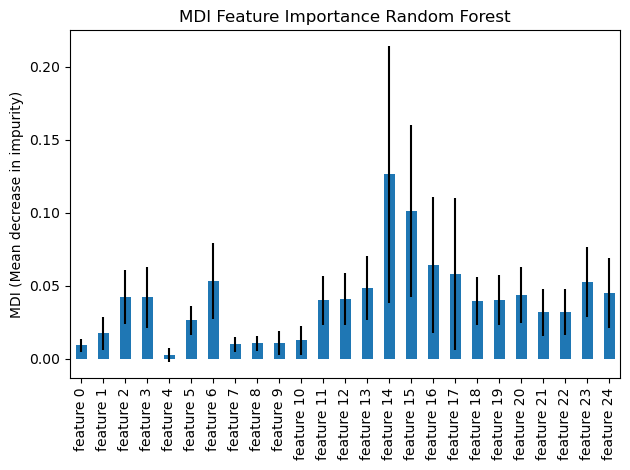

In [117]:
#fitting random forest to assist with feature importance - different to the KNN model earlier 

#naming features 0 to as many exist within the model
feature_names = [f"feature {i}" for i in range(col_X_train.shape[1])]


#including random state in here so that it can be reproduced - arbitrary number is used 
random_forest_classifier = RandomForestClassifier(random_state=14)
random_forest_classifier.fit(col_X_train, col_y_train)

#creating our MDI values using the random forest classifier 
feat_importances = random_forest_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest_classifier.estimators_], axis=0)

#plotting our MDI for features - this will make it easier to interpret 
forest_importances = pd.Series(feat_importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("MDI Feature Importance Random Forest")
ax.set_ylabel("MDI (Mean decrease in impurity)")
fig.tight_layout()

Feature: 0, Score: 0.10873
Feature: 1, Score: 14.05917
Feature: 2, Score: -0.54684
Feature: 3, Score: -11.29480
Feature: 4, Score: 0.63448
Feature: 5, Score: -0.82763
Feature: 6, Score: 2.72897
Feature: 7, Score: 0.50661
Feature: 8, Score: -0.51166
Feature: 9, Score: 1.49273
Feature: 10, Score: -1.38593
Feature: 11, Score: 11.26677
Feature: 12, Score: -11.42025
Feature: 13, Score: -0.34132
Feature: 14, Score: 0.67414
Feature: 15, Score: -0.16683
Feature: 16, Score: -0.46720
Feature: 17, Score: 0.70643
Feature: 18, Score: -13.08819
Feature: 19, Score: 5.64503
Feature: 20, Score: 6.02006
Feature: 21, Score: 0.35733
Feature: 22, Score: -0.22270
Feature: 23, Score: -1.26427
Feature: 24, Score: 0.16185


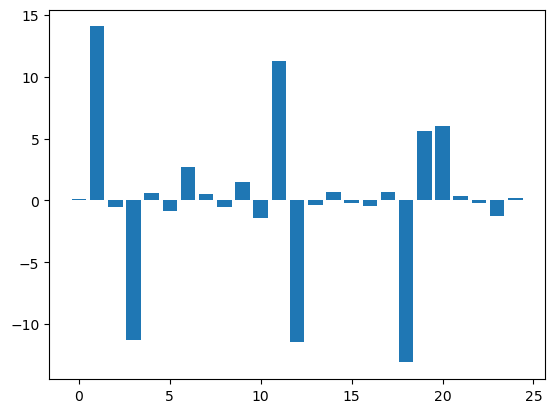

In [118]:
# linear regression feature importance

# our model will be a linear regression model 
model = LinearRegression()
# fit the model
model.fit(col_X_train, col_y_train)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# Correlation matrix 

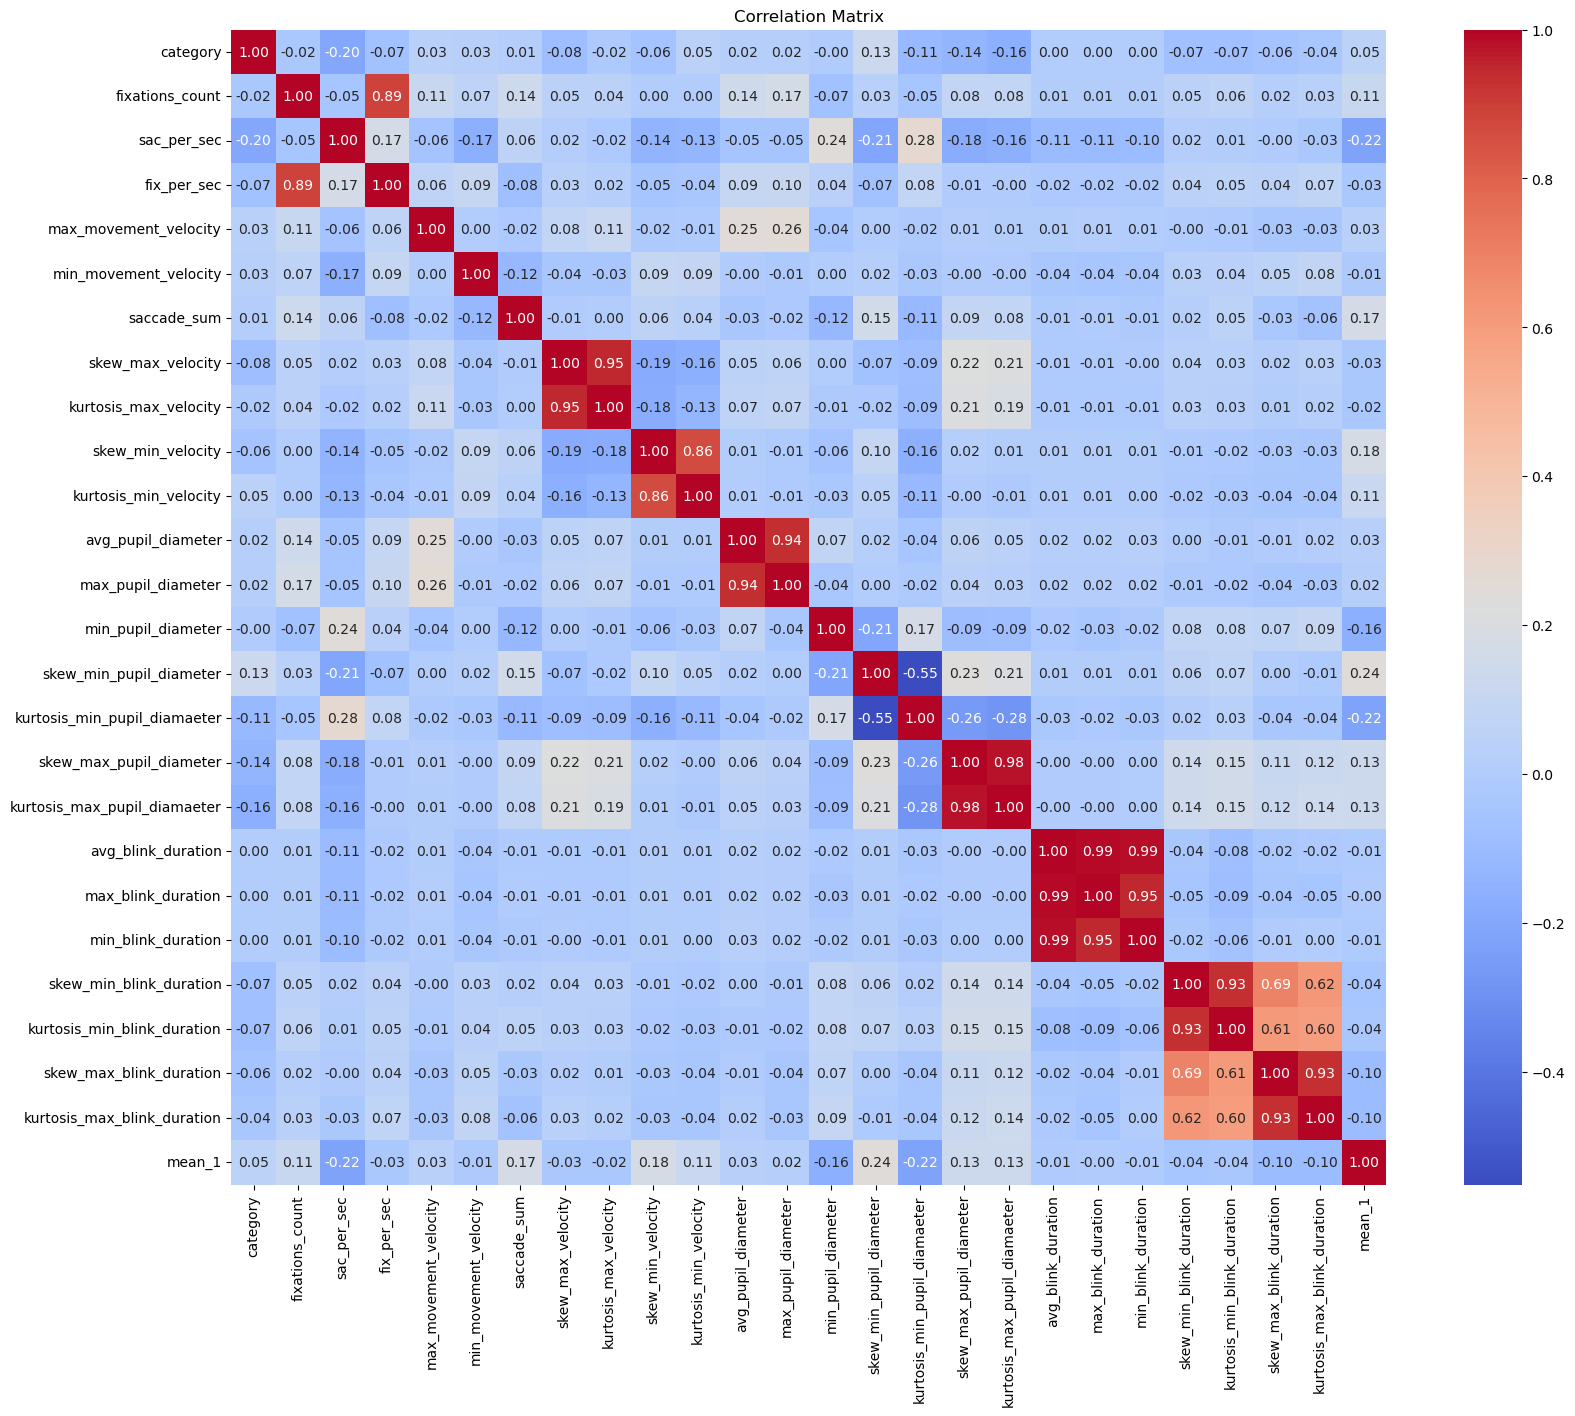

In [119]:
import seaborn as sns
import pandas as pd

# Assuming colet_final_df is your DataFrame
colet_df_features = colet_final_df.drop(['file', 'task'], axis=1)

# Calculate the correlation matrix
correlation_matrix = colet_df_features.corr()

# Display the correlation matrix as a table using seaborn
plt.figure(figsize=(20, 15))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.show()

# Mutual information 

#https://machinelearningmastery.com/feature-selection-with-numerical-input-data/

Feature 0: 0.000000
Feature 1: 0.046933
Feature 2: 0.201334
Feature 3: 0.506745
Feature 4: 0.030380
Feature 5: 0.019544
Feature 6: 0.075528
Feature 7: 0.166622
Feature 8: 0.169547
Feature 9: 0.175180
Feature 10: 0.170807
Feature 11: 0.159714
Feature 12: 0.170579
Feature 13: 0.186026
Feature 14: 0.256523
Feature 15: 0.259068
Feature 16: 0.266429
Feature 17: 0.258285
Feature 18: 0.131088
Feature 19: 0.146753
Feature 20: 0.144764
Feature 21: 0.168768
Feature 22: 0.169446
Feature 23: 0.167952
Feature 24: 0.175712


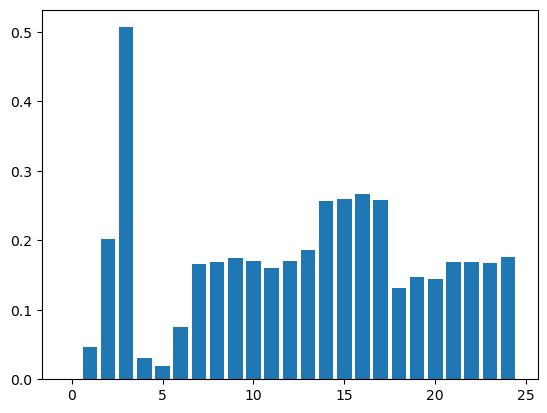

In [120]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# feature selection
def select_features(X_train, y_train, X_test):
 # configure to select all features
 fs = SelectKBest(score_func=mutual_info_classif, k='all')
 # learn relationship from training data
 fs.fit(X_train, y_train)
 # transform train input data
 X_train_fs = fs.transform(X_train)
 # transform test input data
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(col_X_train, col_y_train, col_X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

# Converting tabular data to images

#https://www.kaggle.com/code/taranmarley/data-images-cnn

#reshape data (we have already scaled it early on)

y_scaler =  preprocessing.StandardScaler().fit(col_y_train.values.reshape(-1, 1))
y_scaled_train = y_scaler.transform(col_y_train.values.reshape(-1, 1))
y_scaled_test = y_scaler.transform(col_y_test.values.reshape(-1, 1))

#conversion to images

model = Tab2Img()
train_images = model.fit_transform(col_X_train, y_scaled_train)
val_images = model.transform(col_X_test)
test_images = model.transform(col_X_test)

fig,ax = plt.subplots(2,5)
for i in range(10):
    nparray = test_images[i].reshape(17,17)
    image = Image.fromarray(nparray * 255)
    ax[i%2][i//2].imshow(image)
fig.show()

# Maching learning models

## SVM

# original split (normal vs abnormal)

In [121]:
# parameters for the grid search
param_grid = {'C': [0.1, 1, 10, 100, 1000, 10000], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]} 

#verbose = 1 to limit the amount of output we see from python   
gridsearch = GridSearchCV(SVC(),  param_grid, refit = True, cv = 10, verbose = 1, scoring='accuracy')
  
# fitting the gridsearch onto the model - using our testing data
gridsearch.fit(col_X_train, col_y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [122]:
# optimal hyperparameters 
print(gridsearch.best_params_)
  
# best estimators
print(gridsearch.best_estimator_)

#save parameters to input into the model 
svm_colet_hyper = gridsearch.best_params_
best_score = gridsearch.best_score_

{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=1000, gamma=1)


In [123]:
#creating the SVC model

# using hyperparmaters identified earlier, we can call these as we saved them, saves a lot of time 
support_vc=SVC(C = svm_colet_hyper['C'], 
gamma=svm_colet_hyper['gamma'], 
kernel=svm_colet_hyper['kernel'], 
random_state = 52) 

# fit to training set
support_vc.fit(col_X_train,col_y_train)

# predictions on test set
y_pred=support_vc.predict(col_X_test)

#accuracy score
acc = accuracy_score(col_y_test,y_pred)

# F1 score

print(classification_report(col_y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8792    0.8701    0.8746      1255
           2     0.7052    0.7222    0.7136       540

    accuracy                         0.8256      1795
   macro avg     0.7922    0.7962    0.7941      1795
weighted avg     0.8269    0.8256    0.8262      1795



# C1 vs C2

In [124]:
# parameters for the grid search
param_grid = {'C': [0.1, 1, 10, 100, 1000, 10000], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]} 

#verbose = 1 to limit the amount of output we see from python   
gridsearch = GridSearchCV(SVC(),  param_grid, refit = True, cv = 10, verbose = 1, scoring='accuracy')
  
# fitting the gridsearch onto the model - using our testing data
gridsearch.fit(col_X_train_c1_c2, col_y_train_c1_c2)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [125]:
# optimal hyperparameters 
print(gridsearch.best_params_)
  
# best estimators
print(gridsearch.best_estimator_)

#save parameters to input into the model 
svm_colet_hyper = gridsearch.best_params_
best_score = gridsearch.best_score_

{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=1000, gamma=1)


In [126]:
#creating the SVC model

# using hyperparmaters identified earlier, we can call these as we saved them, saves a lot of time 
support_vc=SVC(C = svm_colet_hyper['C'], 
gamma=svm_colet_hyper['gamma'], 
kernel=svm_colet_hyper['kernel'], 
random_state = 52) 

# fit to training set
support_vc.fit(col_X_train_c1_c2,col_y_train_c1_c2)

# predictions on test set
y_pred=support_vc.predict(col_X_test_c1_c2)

#accuracy score
acc = accuracy_score(col_y_test_c1_c2,y_pred)

# F1 score

print(classification_report(col_y_test_c1_c2, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8372    0.8727    0.8546       542
           1     0.8720    0.8363    0.8538       562

    accuracy                         0.8542      1104
   macro avg     0.8546    0.8545    0.8542      1104
weighted avg     0.8549    0.8542    0.8542      1104



# C1 vs C3

In [ ]:
# parameters for the grid search
param_grid = {'C': [0.1, 1, 10, 100, 1000, 10000], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]} 

#verbose = 1 to limit the amount of output we see from python   
gridsearch = GridSearchCV(SVC(),  param_grid, refit = True, cv = 10, verbose = 1, scoring='accuracy')
  
# fitting the gridsearch onto the model - using our testing data
gridsearch.fit(col_X_train_c1_c3, col_y_train_c1_c3)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


In [ ]:
col_y_train_c1_c3

In [ ]:
# optimal hyperparameters 
print(gridsearch.best_params_)
  
# best estimators
print(gridsearch.best_estimator_)

#save parameters to input into the model 
svm_colet_hyper = gridsearch.best_params_
best_score = gridsearch.best_score_

In [ ]:
#creating the SVC model

# using hyperparmaters identified earlier, we can call these as we saved them, saves a lot of time 
support_vc=SVC(C = svm_colet_hyper['C'], 
gamma=svm_colet_hyper['gamma'], 
kernel=svm_colet_hyper['kernel'], 
random_state = 52) 

# fit to training set
support_vc.fit(col_X_train_c1_c3,col_y_train_c1_c3)

# predictions on test set
y_pred=support_vc.predict(col_X_test_c1_c3)

#accuracy score
acc = accuracy_score(col_y_test_c1_c3,y_pred)

# F1 score

print(classification_report(col_y_test_c1_c3, y_pred, digits=4))

# C2 vs C3

In [ ]:
# parameters for the grid search
param_grid = {'C': [0.1, 1, 10, 100, 1000, 10000], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]} 

#verbose = 1 to limit the amount of output we see from python   
gridsearch = GridSearchCV(SVC(),  param_grid, refit = True, cv = 10, verbose = 1, scoring='accuracy')
  
# fitting the gridsearch onto the model - using our testing data
gridsearch.fit(col_X_train_c2_c3, col_y_train_c2_c3)

In [ ]:
# optimal hyperparameters 
print(gridsearch.best_params_)
  
# best estimators
print(gridsearch.best_estimator_)

#save parameters to input into the model 
svm_colet_hyper = gridsearch.best_params_
best_score = gridsearch.best_score_

In [ ]:
#creating the SVC model

# using hyperparmaters identified earlier, we can call these as we saved them, saves a lot of time 
support_vc=SVC(C = svm_colet_hyper['C'], 
gamma=svm_colet_hyper['gamma'], 
kernel=svm_colet_hyper['kernel'], 
random_state = 52) 

# fit to training set
support_vc.fit(col_X_train_c2_c3,col_y_train_c2_c3)

# predictions on test set
y_pred=support_vc.predict(col_X_test_c2_c3)

#accuracy score
acc = accuracy_score(col_y_test_c2_c3,y_pred)

# F1 score

print(classification_report(col_y_test_c2_c3, y_pred, digits=4))

## CART

# Original approach (normal vs abnormal)

In [ ]:
decist = DecisionTreeClassifier(random_state=1)
# Createing our grid of hyperparameters - these are what will be searched by the grid 
params_decist = {
'max_depth': [2, 3,4,5, 6,8,10],
'min_samples_leaf': [0.04, 0.06, 0.08, 0.10,0.2,0.4],
'max_features': [0.2, 0.4,0.6, 0.8, 0.10,0.2,0.4]
}
# doing our cross fold search through the grid, checkign by accuracy 
#making use of gridsearch to find the optimal values - note verbose = 1 to limit the amount of output we see from python  
grid_decist = GridSearchCV(estimator=decist,
param_grid=params_decist,
scoring=
'accuracy'
,
cv=10,
n_jobs=-1)

In [ ]:
# Fitting the grid to our training data to then find our best hyperparameters 
grid_decist.fit(col_X_train, col_y_train)

#print best hyperparameters as found earlier - these will be used to run our model 
cart_colet_hyper = grid_decist.best_params_
print('Best hyerparameters for CART:', cart_colet_hyper)

In [ ]:
#create teh final model with our best hyperparameters 

final_model = DecisionTreeClassifier(max_depth = cart_colet_hyper['max_depth'], 
                                     max_features = cart_colet_hyper['max_features'], min_samples_leaf = cart_colet_hyper['min_samples_leaf'], random_state = 50)
final_model.fit(col_X_train, col_y_train)

print(final_model)

#test them 
expected_y  = col_y_test
predicted_y = final_model.predict(col_X_test)
#predicting values from logistic regression and viewing our test score
y_pred = final_model.predict(col_X_test)
print('Accuracy of CART classifier on test set: {:.4f}'.format(final_model.score(col_X_test, col_y_test)))

# F1 score
print(classification_report(col_y_test, y_pred, digits=4))

# c1 vs c2

In [ ]:
decist = DecisionTreeClassifier(random_state=1)
# Createing our grid of hyperparameters - these are what will be searched by the grid 
params_decist = {
'max_depth': [2, 3,4,5, 6,8,10],
'min_samples_leaf': [0.04, 0.06, 0.08, 0.10,0.2,0.4],
'max_features': [0.2, 0.4,0.6, 0.8, 0.10,0.2,0.4]
}
# doing our cross fold search through the grid, checkign by accuracy 
#making use of gridsearch to find the optimal values - note verbose = 1 to limit the amount of output we see from python  
grid_decist = GridSearchCV(estimator=decist,
param_grid=params_decist,
scoring=
'accuracy'
,
cv=10,
n_jobs=-1)

In [ ]:
# Fitting the grid to our training data to then find our best hyperparameters 
grid_decist.fit(col_X_train_c1_c2, col_y_train_c1_c2)

#print best hyperparameters as found earlier - these will be used to run our model 
cart_colet_hyper = grid_decist.best_params_
print('Best hyerparameters for CART:', cart_colet_hyper)

In [ ]:
#create teh final model with our best hyperparameters 

final_model = DecisionTreeClassifier(max_depth = cart_colet_hyper['max_depth'], 
                                     max_features = cart_colet_hyper['max_features'], min_samples_leaf = cart_colet_hyper['min_samples_leaf'], random_state = 50)
final_model.fit(col_X_train_c1_c2, col_y_train_c1_c2)

print(final_model)

#test them 
expected_y  = col_y_test_c1_c2
predicted_y = final_model.predict(col_X_test_c1_c2)
#predicting values from logistic regression and viewing our test score
y_pred = final_model.predict(col_X_test_c1_c2)
print('Accuracy of CART classifier on test set: {:.4f}'.format(final_model.score(col_X_test_c1_c2, col_y_test_c1_c2)))

# F1 score
print(classification_report(col_y_test_c1_c2, y_pred, digits=4))

# c1 vs c3

In [ ]:
decist = DecisionTreeClassifier(random_state=1)
# Createing our grid of hyperparameters - these are what will be searched by the grid 
params_decist = {
'max_depth': [2, 3,4,5, 6,8,10],
'min_samples_leaf': [0.04, 0.06, 0.08, 0.10,0.2,0.4],
'max_features': [0.2, 0.4,0.6, 0.8, 0.10,0.2,0.4]
}
# doing our cross fold search through the grid, checkign by accuracy 
#making use of gridsearch to find the optimal values - note verbose = 1 to limit the amount of output we see from python  
grid_decist = GridSearchCV(estimator=decist,
param_grid=params_decist,
scoring=
'accuracy'
,
cv=10,
n_jobs=-1)

In [ ]:
# Fitting the grid to our training data to then find our best hyperparameters 
grid_decist.fit(col_X_train_c1_c3, col_y_train_c1_c3)

#print best hyperparameters as found earlier - these will be used to run our model 
cart_colet_hyper = grid_decist.best_params_
print('Best hyerparameters for CART:', cart_colet_hyper)

In [ ]:
#create teh final model with our best hyperparameters 

final_model = DecisionTreeClassifier(max_depth = cart_colet_hyper['max_depth'], 
                                     max_features = cart_colet_hyper['max_features'], min_samples_leaf = cart_colet_hyper['min_samples_leaf'], random_state = 50)
final_model.fit(col_X_train_c1_c3, col_y_train_c1_c3)

print(final_model)

#test them 
expected_y  = col_y_test_c1_c3
predicted_y = final_model.predict(col_X_test_c1_c3)
#predicting values from logistic regression and viewing our test score
y_pred = final_model.predict(col_X_test_c1_c3)
print('Accuracy of CART classifier on test set: {:.4f}'.format(final_model.score(col_X_test_c1_c3, col_y_test_c1_c3)))

# F1 score
print(classification_report(col_y_test_c1_c3, y_pred, digits=4))

# c2 vs c3

In [ ]:
decist = DecisionTreeClassifier(random_state=1)
# Createing our grid of hyperparameters - these are what will be searched by the grid 
params_decist = {
'max_depth': [2, 3,4,5, 6,8,10],
'min_samples_leaf': [0.04, 0.06, 0.08, 0.10,0.2,0.4],
'max_features': [0.2, 0.4,0.6, 0.8, 0.10,0.2,0.4]
}
# doing our cross fold search through the grid, checkign by accuracy 
#making use of gridsearch to find the optimal values - note verbose = 1 to limit the amount of output we see from python  
grid_decist = GridSearchCV(estimator=decist,
param_grid=params_decist,
scoring=
'accuracy'
,
cv=10,
n_jobs=-1)

In [ ]:
# Fitting the grid to our training data to then find our best hyperparameters 
grid_decist.fit(col_X_train_c2_c3, col_y_train_c2_c3)

#print best hyperparameters as found earlier - these will be used to run our model 
cart_colet_hyper = grid_decist.best_params_
print('Best hyerparameters for CART:', cart_colet_hyper)

In [ ]:
#create teh final model with our best hyperparameters 

final_model = DecisionTreeClassifier(max_depth = cart_colet_hyper['max_depth'], 
                                     max_features = cart_colet_hyper['max_features'], min_samples_leaf = cart_colet_hyper['min_samples_leaf'], random_state = 50)
final_model.fit(col_X_train_c2_c3, col_y_train_c2_c3)

print(final_model)

#test them 
expected_y  = col_y_test_c2_c3
predicted_y = final_model.predict(col_X_test_c2_c3)
#predicting values from logistic regression and viewing our test score
y_pred = final_model.predict(col_X_test_c2_c3)
print('Accuracy of CART classifier on test set: {:.4f}'.format(final_model.score(col_X_test_c2_c3, col_y_test_c2_c3)))

# F1 score
print(classification_report(col_y_test_c2_c3, y_pred, digits=4))

## GNB

# original approach (normal vs abnormal)

In [ ]:
#set cross validation method
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=10, 
                                    random_state=52)

In [ ]:
#create model and gridsearch using cv method noted above 
model = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=model, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(col_X_test)

gs_NB.fit(col_X_test, col_y_test)

#get best parametesr 
gnb_colet_params = gs_NB.best_params_

In [ ]:
nb = GaussianNB(var_smoothing = gnb_colet_params['var_smoothing'])
nb.fit(col_X_test, col_y_test)
# make predictions on test set
y_pred=nb.predict(col_X_test)

#confm = confusion_matrix(col_y_test, y_pred)
acc = accuracy_score(col_y_test,y_pred)

print(classification_report(col_y_test, y_pred, digits=4))

In [ ]:
# C1 vs C2

In [ ]:
#create model and gridsearch using cv method noted above 
model = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=model, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(col_X_test_c1_c2)

gs_NB.fit(col_X_test_c1_c2, col_y_test_c1_c2)

#get best parametesr 
gnb_colet_params = gs_NB.best_params_

In [ ]:
nb = GaussianNB(var_smoothing = gnb_colet_params['var_smoothing'])
nb.fit(col_X_test_c1_c2, col_y_test_c1_c2)
# make predictions on test set
y_pred=nb.predict(col_X_test_c1_c2)

#confm = confusion_matrix(col_y_test, y_pred)
acc = accuracy_score(col_y_test_c1_c2,y_pred)

print(classification_report(col_y_test_c1_c2, y_pred, digits=4))

# c1 vs c3

In [ ]:
#create model and gridsearch using cv method noted above 
model = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=model, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(col_X_test_c1_c3)

gs_NB.fit(col_X_test_c1_c3, col_y_test_c1_c3)

#get best parametesr 
gnb_colet_params = gs_NB.best_params_

In [ ]:
nb = GaussianNB(var_smoothing = gnb_colet_params['var_smoothing'])
nb.fit(col_X_test_c1_c3, col_y_test_c1_c3)
# make predictions on test set
y_pred=nb.predict(col_X_test_c1_c3)

#confm = confusion_matrix(col_y_test, y_pred)
acc = accuracy_score(col_y_test_c1_c3,y_pred)

print(classification_report(col_y_test_c1_c3, y_pred, digits=4))

# c2 vs c3

In [ ]:
#create model and gridsearch using cv method noted above 
model = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=model, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(col_X_test_c2_c3)

gs_NB.fit(col_X_test_c2_c3, col_y_test_c2_c3)

#get best parametesr 
gnb_colet_params = gs_NB.best_params_

In [ ]:
nb = GaussianNB(var_smoothing = gnb_colet_params['var_smoothing'])
nb.fit(col_X_test_c2_c3, col_y_test_c2_c3)
# make predictions on test set
y_pred=nb.predict(col_X_test_c2_c3)

#confm = confusion_matrix(col_y_test, y_pred)
acc = accuracy_score(col_y_test_c2_c3,y_pred)

print(classification_report(col_y_test_c2_c3, y_pred, digits=4))

## Light GBM


colet_gbm = lgb.LGBMClassifier(verbose=0)

cgbm_param_grid = {'learning_rate': [0.2, 0.1, 0.05, 0.01, 0.001, 0.001], 'n_estimators': [50, 100, 150, 200, 250, 300, 400, 500], 'max_depth': [1, 3, 5, 7, 10],  }

gs_cgbm = GridSearchCV(estimator=colet_gbm, param_grid=cgbm_param_grid, cv=cv_method)

gs_cgbm.fit(col_X_train, col_y_train)

gbm_colet_params = gs_cgbm.best_params_

In [ ]:
#Use default parameters 

colet_gbm = lgb.LGBMClassifier(learning_rate = gbm_colet_params['learning_rate'], max_depth = gbm_colet_params['max_depth'], n_estimators = gbm_colet_params['n_estimators'], verbose=0)
colet_gbm.fit(col_X_train, col_y_train, eval_set=[(col_X_train, col_y_train),(col_X_test, col_y_test)])

## XGBoost

In [ ]:
#XGBoost 

#changing below to markdown because we are excluding xgboost anyway 

import xgboost as xgbc

#https://www.kaggle.com/code/emmanuelfwerr/xgboost-multi-class-classification#XGBoost-Classifier
#https://xgboost.readthedocs.io/en/stable/parameter.html

xgb = xgbc.XGBClassifier(objective = 'binary:logistic', #want a class output, softmax is the most appropriate
           num_class = 2, #we already know we have 3 classes
           #early_stopping_rounds=10, #if nothing happens after 10 rounds... stop
           eval_metric=['auc'], #AUC for consistency with TabNet, perhaps RMSE and multiclass logloss? 
           seed = 16 #set seed for consistency 
          )

xgb.fit(col_X_test, col_y_test)
y_pred = xgb.predict(col_X_test)

acc = accuracy_score(col_y_test,y_pred)

print(classification_report(col_y_test, y_pred, digits=4))


## KNN

# original approach (normal vs abnormal) 

In [ ]:
#KNN

#COLET AUTHORS FOUND THIS PREDICTED REALLY WELL, IT SHOULD BE INCLUDED... 

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 2)

knn.fit(col_X_test, col_y_test)
y_pred=knn.predict(col_X_test)

acc = accuracy_score(col_y_test,y_pred)

print(classification_report(col_y_test, y_pred, digits=4))

# C1 vs C2

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 2)

knn.fit(col_X_test_c1_c2, col_y_test_c1_c2)
y_pred=knn.predict(col_X_test_c1_c2)

acc = accuracy_score(col_y_test_c1_c2,y_pred)

print(classification_report(col_y_test_c1_c2, y_pred, digits=4))

# c1 vs c3

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 2)

knn.fit(col_X_test_c1_c3, col_y_test_c1_c3)
y_pred=knn.predict(col_X_test_c1_c3)

acc = accuracy_score(col_y_test_c1_c3,y_pred)

print(classification_report(col_y_test_c1_c3, y_pred, digits=4))

# c2 vs c3

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 2)

knn.fit(col_X_test_c2_c3, col_y_test_c2_c3)
y_pred=knn.predict(col_X_test_c2_c3)

acc = accuracy_score(col_y_test_c2_c3,y_pred)

print(classification_report(col_y_test_c2_c3, y_pred, digits=4))

# Deep Learning Approach

# TabNet

# original approach - normal vs abnormal 

In [ ]:
classifier = TabNetClassifier(seed=42, verbose = 0, n_steps = 5)
classifier.fit(X_train=col_X_train, y_train=col_y_train,
               patience=5,max_epochs=10000,
               eval_metric=['auc'])

In [ ]:
#testing below, have added in digits = 4... can remove if it failx

y_pred=classifier.predict(col_X_test)
print(classification_report(col_y_test, y_pred, digits=4))

# C1 vs C2

In [ ]:
classifier = TabNetClassifier(seed=42, verbose = 0, n_steps = 5)
classifier.fit(X_train=col_X_train_c1_c2, y_train=col_y_train_c1_c2,
               patience=5,max_epochs=10000,
               eval_metric=['auc'])

In [ ]:
#testing below, have added in digits = 4... can remove if it failx

y_pred=classifier.predict(col_X_test_c1_c2)
print(classification_report(col_y_test_c1_c2, y_pred, digits=4))

# c1 vs c3

In [ ]:
classifier = TabNetClassifier(seed=42, verbose = 0, n_steps = 5)
classifier.fit(X_train=col_X_train_c1_c3, y_train=col_y_train_c1_c3,
               patience=5,max_epochs=10000,
               eval_metric=['auc'])

In [ ]:
#testing below, have added in digits = 4... can remove if it failx

y_pred=classifier.predict(col_X_test_c1_c3)
print(classification_report(col_y_test_c1_c3, y_pred, digits=4))

# c2 vs c3

In [ ]:
classifier = TabNetClassifier(seed=42, verbose = 0, n_steps = 5)
classifier.fit(X_train=col_X_train_c2_c3, y_train=col_y_train_c2_c3,
               patience=5,max_epochs=10000,
               eval_metric=['auc'])

In [ ]:
#testing below, have added in digits = 4... can remove if it failx

y_pred=classifier.predict(col_X_test_c2_c3)
print(classification_report(col_y_test_c2_c3, y_pred, digits=4))

# Self normalizing neural network

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#SNN model
model = Sequential()
model.add(Dense(units=128, activation="selu", kernel_initializer="lecun_normal", input_shape=(25,))) # col_X_train.shape[1:]selu is a self-normalization method, lecun works well with it 
model.add(Dense(units=32, activation="selu", kernel_initializer="lecun_normal")) #selu is a self-normalization method, lecun works well with it
model.add(Dense(units=32, activation="selu", kernel_initializer="lecun_normal")) #selu is a self-normalization method, lecun works well with it
model.add(Dense(units=2, activation="sigmoid")) #sigmoid for binary, lecun works well with it

model.compile(
        optimizer="adam", #adam is a good all-rounder 
        loss="binary_crossentropy", #binary crossentropy for a binary classification problem 
        metrics=["AUC"] #AUC for consistency 

    )

model.summary()

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.8,
    patience=10,
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=60,
    restore_best_weights=True
)

callbacks = [reduce_lr, early_stop]

# original approach (normal vs abnormal)

In [ ]:
#reshape X train data 

X_train = col_X_train.reshape(col_X_train.shape[0], col_X_train.shape[1], 1)
X_test = col_X_test.reshape(col_X_test.shape[0], col_X_test.shape[1], 1)

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Convert pandas Series to NumPy arrays
col_y_train_array = np.array(col_y_train)
col_y_test_array = np.array(col_y_test)

# Reshape the arrays to have a shape of (n_samples, 1)
col_y_train_reshaped = col_y_train_array.reshape(-1, 1)
col_y_test_reshaped = col_y_test_array.reshape(-1, 1)

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the target variables
col_y_train_encoded = encoder.fit_transform(col_y_train_reshaped)
col_y_test_encoded = encoder.transform(col_y_test_reshaped)

print("Shapes after encoding:")
print("col_y_train_encoded shape:", col_y_train_encoded.shape)
print("col_y_test_encoded shape:", col_y_test_encoded.shape)

# c1 vs c2

In [ ]:
#reshape X train data 

X_train_c1_c2 = col_X_train_c1_c2.reshape(col_X_train_c1_c2.shape[0], col_X_train_c1_c2.shape[1], 1)
X_test_c1_c2 = col_X_test_c1_c2.reshape(col_X_test_c1_c2.shape[0], col_X_test_c1_c2.shape[1], 1)

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Convert pandas Series to NumPy arrays
col_y_train_array = np.array(col_y_train_c1_c2)
col_y_test_array = np.array(col_y_test_c1_c2)

# Reshape the arrays to have a shape of (n_samples, 1)
col_y_train_reshaped_c1_c2 = col_y_train_array.reshape(-1, 1)
col_y_test_reshaped_c1_c2 = col_y_test_array.reshape(-1, 1)

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the target variables
col_y_train_encoded_c1_c2 = encoder.fit_transform(col_y_train_reshaped_c1_c2)
col_y_test_encoded_c1_c2 = encoder.transform(col_y_test_reshaped_c1_c2)

print("Shapes after encoding:")
print("col_y_train_encoded shape:", col_y_train_encoded_c1_c2.shape)
print("col_y_test_encoded shape:", col_y_test_encoded_c1_c2.shape)

# c1 vs c3

In [ ]:
#reshape X train data 

X_train_c1_c3 = col_X_train_c1_c3.reshape(col_X_train_c1_c3.shape[0], col_X_train_c1_c3.shape[1], 1)
X_test_c1_c3 = col_X_test_c1_c3.reshape(col_X_test_c1_c3.shape[0], col_X_test_c1_c3.shape[1], 1)

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Convert pandas Series to NumPy arrays
col_y_train_array = np.array(col_y_train_c1_c3)
col_y_test_array = np.array(col_y_test_c1_c3)

# Reshape the arrays to have a shape of (n_samples, 1)
col_y_train_reshaped_c1_c3 = col_y_train_array.reshape(-1, 1)
col_y_test_reshaped_c1_c3 = col_y_test_array.reshape(-1, 1)

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the target variables
col_y_train_encoded_c1_c3 = encoder.fit_transform(col_y_train_reshaped_c1_c3)
col_y_test_encoded_c1_c3 = encoder.transform(col_y_test_reshaped_c1_c3)

print("Shapes after encoding:")
print("col_y_train_encoded shape:", col_y_train_encoded_c1_c3.shape)
print("col_y_test_encoded shape:", col_y_test_encoded_c1_c3.shape)

# c2 vs c3

In [ ]:
X_train_c2_c3 = col_X_train_c2_c3.reshape(col_X_train_c2_c3.shape[0], col_X_train_c2_c3.shape[1], 1)
X_test_c2_c3 = col_X_test_c2_c3.reshape(col_X_test_c2_c3.shape[0], col_X_test_c2_c3.shape[1], 1)

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Convert pandas Series to NumPy arrays
col_y_train_array = np.array(col_y_train_c2_c3)
col_y_test_array = np.array(col_y_test_c2_c3)

# Reshape the arrays to have a shape of (n_samples, 1)
col_y_train_reshaped_c2_c3 = col_y_train_array.reshape(-1, 1)
col_y_test_reshaped_c2_c3 = col_y_test_array.reshape(-1, 1)

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the target variables
col_y_train_encoded_c2_c3 = encoder.fit_transform(col_y_train_reshaped_c2_c3)
col_y_test_encoded_c2_c3 = encoder.transform(col_y_test_reshaped_c2_c3)

print("Shapes after encoding:")
print("col_y_train_encoded shape:", col_y_train_encoded_c2_c3.shape)
print("col_y_test_encoded shape:", col_y_test_encoded_c2_c3.shape)

# original approach (normal vs abnormal)

In [ ]:
num_classes = 2

model.fit(
        X_train,
        col_y_train_encoded,
        validation_data=(col_X_test, col_y_test_encoded),
        epochs=10000,
        batch_size=685,
        callbacks=[reduce_lr, early_stop],
        verbose=False,
    
    )

In [ ]:
#https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la
#input to GPT
#y_pred=model.predict(X_test)
#y_pred=np.argmax(y_pred, axis=1)
#print(classification_report(col_y_test_encoded, y_pred, digits=4))

#ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

#GPT response
#code below: 


from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

# Assuming y_pred=model.predict(X_test) has been defined earlier
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Assuming col_y_test_encoded, X_test, and model are defined earlier

# Convert col_y_test_encoded to multiclass format using LabelBinarizer
lb = LabelBinarizer()
col_y_test_multiclass = lb.fit_transform(col_y_test_encoded)
col_y_test_multiclass = np.argmax(col_y_test_multiclass, axis=1)

# Print the classification report
print(classification_report(col_y_test_multiclass, y_pred, digits=4))

# c1 vs C2

In [ ]:
model.fit(
        X_train_c1_c2,
        col_y_train_encoded_c1_c2,
        validation_data=(col_X_test_c1_c2, col_y_test_encoded_c1_c2),
        epochs=10000,
        batch_size=685,
        callbacks=[reduce_lr, early_stop],
        verbose=False,
    
    )

In [ ]:
#https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la
#input to GPT
#y_pred=model.predict(X_test)
#y_pred=np.argmax(y_pred, axis=1)
#print(classification_report(col_y_test_encoded, y_pred, digits=4))

#ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

#GPT response
#code below: 


from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

# Assuming y_pred=model.predict(X_test) has been defined earlier
y_pred = model.predict(X_test_c1_c2)
y_pred = np.argmax(y_pred, axis=1)

# Assuming col_y_test_encoded, X_test, and model are defined earlier

# Convert col_y_test_encoded to multiclass format using LabelBinarizer
lb = LabelBinarizer()
col_y_test_multiclass = lb.fit_transform(col_y_test_encoded_c1_c2)
col_y_test_multiclass = np.argmax(col_y_test_multiclass, axis=1)

# Print the classification report
print(classification_report(col_y_test_multiclass, y_pred, digits=4))

# c1 vs c3

In [ ]:
model.fit(
        X_train_c1_c3,
        col_y_train_encoded_c1_c3,
        validation_data=(col_X_test_c1_c3, col_y_test_encoded_c1_c3),
        epochs=10000,
        batch_size=685,
        callbacks=[reduce_lr, early_stop],
        verbose=False,
    
    )

In [ ]:
#https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la
#input to GPT
#y_pred=model.predict(X_test)
#y_pred=np.argmax(y_pred, axis=1)
#print(classification_report(col_y_test_encoded, y_pred, digits=4))

#ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

#GPT response
#code below: 


from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

# Assuming y_pred=model.predict(X_test) has been defined earlier
y_pred = model.predict(X_test_c1_c3)
y_pred = np.argmax(y_pred, axis=1)

# Assuming col_y_test_encoded, X_test, and model are defined earlier

# Convert col_y_test_encoded to multiclass format using LabelBinarizer
lb = LabelBinarizer()
col_y_test_multiclass = lb.fit_transform(col_y_test_encoded_c1_c3)
col_y_test_multiclass = np.argmax(col_y_test_multiclass, axis=1)

# Print the classification report
print(classification_report(col_y_test_multiclass, y_pred, digits=4))

# c2 vs c3

In [ ]:
model.fit(
        X_train_c2_c3,
        col_y_train_encoded_c2_c3,
        validation_data=(col_X_test_c2_c3, col_y_test_encoded_c2_c3),
        epochs=10000,
        batch_size=685,
        callbacks=[reduce_lr, early_stop],
        verbose=False,
    
    )

In [ ]:
#https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la
#input to GPT
#y_pred=model.predict(X_test)
#y_pred=np.argmax(y_pred, axis=1)
#print(classification_report(col_y_test_encoded, y_pred, digits=4))

#ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

#GPT response
#code below: 


from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

# Assuming y_pred=model.predict(X_test) has been defined earlier
y_pred = model.predict(X_test_c2_c3)
y_pred = np.argmax(y_pred, axis=1)

# Assuming col_y_test_encoded, X_test, and model are defined earlier

# Convert col_y_test_encoded to multiclass format using LabelBinarizer
lb = LabelBinarizer()
col_y_test_multiclass = lb.fit_transform(col_y_test_encoded_c2_c3)
col_y_test_multiclass = np.argmax(col_y_test_multiclass, axis=1)

# Print the classification report
print(classification_report(col_y_test_multiclass, y_pred, digits=4))

# Multilayer Perceptron 

## Original approach (normal vs abnormal)

In [ ]:
#using code from Gayathri 
from tensorflow.python.keras import regularizers

def mlp_model():
    # Set the input shape
    input_shape = (25,)
    print(f'Feature shape: {input_shape}')
    print("In simple model ..........")
    mlp = Sequential()
    mlp.add(Dense(64, activation='relu', input_shape = input_shape,kernel_initializer='uniform',kernel_regularizer = regularizers.l2(0.001)))
    mlp.add(Dense(32, kernel_initializer = 'uniform', activation='relu',kernel_regularizer = regularizers.l2(0.001)))
    mlp.add(Dense(16,  kernel_initializer = 'uniform', activation='relu',kernel_regularizer = regularizers.l2(0.001)))
    #mlp.add(Dense(8, kernel_initializer = 'uniform', activation='relu',kernel_regularizer = regularizers.l2(0.001)))
    mlp.add(Dense(num_classes, activation='sigmoid'))    
    #mlp.summary()
    #opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)#Adam(lr=5e-5)
    #opt = SGD(lr=0.01, momentum=0.9)
    mlp.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['AUC'])
    print('compile done')
    return mlp

In [ ]:
model = mlp_model()

In [ ]:
model.fit(
        X_train,
        col_y_train_encoded,
        validation_data=(col_X_test, col_y_test_encoded),
        epochs=10000,
        batch_size=685,
        callbacks=[reduce_lr, early_stop],
        verbose=False,
    
    )

In [ ]:
# Assuming y_pred=model.predict(X_test) has been defined earlier
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert col_y_test_encoded to multiclass format using LabelBinarizer
lb = LabelBinarizer()
col_y_test_multiclass = lb.fit_transform(col_y_test_encoded)
col_y_test_multiclass = np.argmax(col_y_test_multiclass, axis=1)

# Print the classification report
print(classification_report(col_y_test_multiclass, y_pred, digits=4))

# c1 vs C2

In [ ]:
model.fit(
        X_train_c1_c2,
        col_y_train_encoded_c1_c2,
        validation_data=(col_X_test_c1_c2, col_y_test_encoded_c1_c2),
        epochs=10000,
        batch_size=685,
        callbacks=[reduce_lr, early_stop],
        verbose=False,
    
    )

In [ ]:
# Assuming y_pred=model.predict(X_test) has been defined earlier
y_pred = model.predict(X_test_c1_c2)
y_pred = np.argmax(y_pred, axis=1)

# Convert col_y_test_encoded to multiclass format using LabelBinarizer
lb = LabelBinarizer()
col_y_test_multiclass = lb.fit_transform(col_y_test_encoded_c1_c2)
col_y_test_multiclass = np.argmax(col_y_test_multiclass, axis=1)

# Print the classification report
print(classification_report(col_y_test_multiclass, y_pred, digits=4))

# C1 vs C3

In [ ]:
model.fit(
        X_train_c1_c3,
        col_y_train_encoded_c1_c3,
        validation_data=(col_X_test_c1_c3, col_y_test_encoded_c1_c3),
        epochs=10000,
        batch_size=685,
        callbacks=[reduce_lr, early_stop],
        verbose=False,
    
    )

In [ ]:
# Assuming y_pred=model.predict(X_test) has been defined earlier
y_pred = model.predict(X_test_c1_c3)
y_pred = np.argmax(y_pred, axis=1)

# Convert col_y_test_encoded to multiclass format using LabelBinarizer
lb = LabelBinarizer()
col_y_test_multiclass = lb.fit_transform(col_y_test_encoded_c1_c3)
col_y_test_multiclass = np.argmax(col_y_test_multiclass, axis=1)

# Print the classification report
print(classification_report(col_y_test_multiclass, y_pred, digits=4))

# c2 vs c3

In [ ]:
model.fit(
        X_train_c2_c3,
        col_y_train_encoded_c2_c3,
        validation_data=(col_X_test_c2_c3, col_y_test_encoded_c2_c3),
        epochs=10000,
        batch_size=685,
        callbacks=[reduce_lr, early_stop],
        verbose=False,
    
    )

In [ ]:
# Assuming y_pred=model.predict(X_test) has been defined earlier
y_pred = model.predict(X_test_c2_c3)
y_pred = np.argmax(y_pred, axis=1)

# Convert col_y_test_encoded to multiclass format using LabelBinarizer
lb = LabelBinarizer()
col_y_test_multiclass = lb.fit_transform(col_y_test_encoded_c2_c3)
col_y_test_multiclass = np.argmax(col_y_test_multiclass, axis=1)

# Print the classification report
print(classification_report(col_y_test_multiclass, y_pred, digits=4))

# 1D CNN

# original approach

In [ ]:
#using code from Gayathri 
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dropout
#from tensorflow.keras.layers import 


def cnn_1d_model():
    
    model = Sequential()
    #Sintput_shape=(x_train.shape[1], 1)
    model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=(25,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Flatten())
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='sigmoid'))
    model.summary()
        
#    #sgd = SGD(lr = 1e-9, momentum = 0.9, decay = 0, nesterov = False)
#    opt = Adadelta(lr=1e-7)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['AUC'])
    
#    model.summary()
    
    return model

In [ ]:
model = cnn_1d_model()

In [ ]:
model.fit(
        X_train,
        col_y_train_encoded,
        validation_data=(col_X_test, col_y_test_encoded),
        epochs=10000,
        batch_size=685,
        callbacks=[reduce_lr, early_stop],
        verbose=False,
    
    )

In [ ]:
# Assuming y_pred=model.predict(X_test) has been defined earlier
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert col_y_test_encoded to multiclass format using LabelBinarizer
lb = LabelBinarizer()
col_y_test_multiclass = lb.fit_transform(col_y_test_encoded)
col_y_test_multiclass = np.argmax(col_y_test_multiclass, axis=1)

# Print the classification report
print(classification_report(col_y_test, y_pred, digits=4))

# c1 vs c2

In [ ]:
model.fit(
        X_train_c1_c2,
        col_y_train_encoded_c1_c2,
        validation_data=(col_X_test_c1_c2, col_y_test_encoded_c1_c2),
        epochs=10000,
        batch_size=685,
        callbacks=[reduce_lr, early_stop],
        verbose=False,
    
    )

In [ ]:
# Assuming y_pred=model.predict(X_test) has been defined earlier
y_pred = model.predict(X_test_c1_c2)
y_pred = np.argmax(y_pred, axis=1)

# Convert col_y_test_encoded to multiclass format using LabelBinarizer
lb = LabelBinarizer()
col_y_test_multiclass = lb.fit_transform(col_y_test_encoded_c1_c2)
col_y_test_multiclass = np.argmax(col_y_test_multiclass, axis=1)

# Print the classification report
print(classification_report(col_y_test_multiclass, y_pred, digits=4))

# c1 vs c3

In [ ]:
model.fit(
        X_train_c1_c3,
        col_y_train_encoded_c1_c3,
        validation_data=(col_X_test_c1_c3, col_y_test_encoded_c1_c3),
        epochs=10000,
        batch_size=685,
        callbacks=[reduce_lr, early_stop],
        verbose=False,
    
    )

In [ ]:
# Assuming y_pred=model.predict(X_test) has been defined earlier
y_pred = model.predict(X_test_c1_c3)
y_pred = np.argmax(y_pred, axis=1)

# Convert col_y_test_encoded to multiclass format using LabelBinarizer
lb = LabelBinarizer()
col_y_test_multiclass = lb.fit_transform(col_y_test_encoded_c1_c3)
col_y_test_multiclass = np.argmax(col_y_test_multiclass, axis=1)

# Print the classification report
print(classification_report(col_y_test_multiclass, y_pred, digits=4))

# c2 vs c3

In [ ]:
model.fit(
        X_train_c2_c3,
        col_y_train_encoded_c2_c3,
        validation_data=(col_X_test_c2_c3, col_y_test_encoded_c2_c3),
        epochs=10000,
        batch_size=685,
        callbacks=[reduce_lr, early_stop],
        verbose=False,
    
    )

In [ ]:
# Assuming y_pred=model.predict(X_test) has been defined earlier
y_pred = model.predict(X_test_c2_c3)
y_pred = np.argmax(y_pred, axis=1)

# Convert col_y_test_encoded to multiclass format using LabelBinarizer
lb = LabelBinarizer()
col_y_test_multiclass = lb.fit_transform(col_y_test_encoded_c2_c3)
col_y_test_multiclass = np.argmax(col_y_test_multiclass, axis=1)

# Print the classification report
print(classification_report(col_y_test_multiclass, y_pred, digits=4))